# Pitch Classification Intro
The purpose of this dataset is to work on a classification pipeline for the pitch type selection.

Importing various packages:

In [1]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Pickling in the data from data_cleaning.ipynb:

In [4]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [5]:
with open('../Data/cleaned_pitch_df.pickle','rb') as read_file:
    pitch_df = pickle.load(read_file)

In [6]:
pitch_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season,Pitch_Family
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,None,NaN,NaN,NaN,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,0.416,2.963,92.9,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.191,2.347,92.8,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.518,3.284,94.1,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.641,1.221,91.0,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,


In [7]:
pitch_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'Pitch_Family'],
      dtype='object')

In [8]:
pitch_df.drop(columns=['Pitch_Family'], inplace=True)

For classification purposes, I'll have the following features for now:
- 'inning', 'top', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed', 'pitcher_run_diff'
- I will be using 'pitch_type' as the label
- First attempt will be to train models on individual pitchers, using the same pipeline steps.  
- For now, I'll be using just this data to set up a workflow.  Once other data (namely, pitch arsenal and hitter clustering) are ready, they will be incorporated.

# Dataframe Prep

## Split: Train/Val and Test

For puposes of training/validating and testing my model(s), I'll be splitting as follows: 
- Train/Val: 2015-2018 seasons
- Test: 2019 season

In [9]:
pitch_df[pitch_df.Season == 2019].shape

(707463, 34)

In [10]:
pitch_df[pitch_df.Season != 2019].shape

(2848371, 34)

Based on the numbers, this is an ~80/20 split in data.

In [11]:
train_df = pitch_df[pitch_df.Season != 2019]

In [12]:
train_df.pitcher_full_name.value_counts()

Max Scherzer        13479
Justin Verlander    12810
Chris Archer        12760
Jose Quintana       12692
Chris Sale          12689
                    ...  
Alexi Amarista          3
Mark Reynolds           3
Phillip Ervin           3
Chris Denorfia          2
Anthony Rizzo           2
Name: pitcher_full_name, Length: 1329, dtype: int64

### First Pitch Types:

Right now, last pitch type, speed, and location is all null for the first pitch of an at-bat, since there aren't any other pitchs in that at bat.  To remove the null information, I will add in the first pitch from the *previous* at bat, since that could inform how a pitcher opens at bats.

### Changing the below to markdown after initial run:

pitchers = train_df.pitcher_full_name.value_counts().index

train_df[train_df.pitch_num == 1]

Commenting out the below after firt run/pickling due to run time:

In [13]:
# for pitcher in pitchers:
#     filtered_df = train_df[(train_df.pitcher_full_name == pitcher) & (train_df.pitch_num == 1)].sort_values(by=['ab_id'])
#     first_pitches = filtered_df.index[1:]
#     for i, first_pitch in enumerate(first_pitches, 1):
#         last_first_pitch = train_df.pitch_type.iloc[filtered_df.index[i-1]]
#         last_first_px = train_df.px.iloc[filtered_df.index[i-1]]
#         last_first_pz = train_df.pz.iloc[filtered_df.index[i-1]]
#         last_first_speed = train_df.start_speed.iloc[filtered_df.index[i-1]]
        
#         train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
#         train_df.last_pitch_px.iloc[first_pitch] = last_first_px
#         train_df.last_pitch_pz.iloc[first_pitch] = last_first_pz
#         train_df.last_pitch_speed.iloc[first_pitch] = last_first_speed
    

train_df.head()

Based on the above, this looks like it worked - I'll pull up an example of another pitcher (Lucas Giolito) to check:

filtered_df = train_df[['ab_id','pitch_type', 'px', 'pz', 'start_speed', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed']][(train_df.pitcher_full_name =='Lucas Giolito') & (train_df.pitch_num == 1)].sort_values(by='ab_id')

filtered_df.head(20)

Perfect, that loots to have worked as intended.  As an aside, it's interesting that 17/20 first pitches here are all four seam fastballs.

Pickling this df, just so I don't have to re-run the first pitch assignments:

pwd

with open('../Data/train_df_post_first.pickle', 'wb') as to_write:
    pickle.dump(train_df, to_write)

Pickling it back in:

In [14]:
with open('../Data/train_df_post_first.pickle','rb') as read_file:
    train_df = pickle.load(read_file)

## Feature Prep

Here, I"ll be preparing the dataframe for modeling.  I'll be starting with just a subset of one pitcher's pitches as a proof of concept, using Max Scherzer's pitch totals, since he has the most of any pitcher.

In [15]:
scherzer_df = train_df[train_df.pitcher_full_name == 'Max Scherzer']

In [16]:
scherzer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   inning             13479 non-null  float64       
 1   batter_id          13479 non-null  int64         
 2   pitcher_id         13479 non-null  int64         
 3   top                13479 non-null  float64       
 4   ab_id              13479 non-null  float64       
 5   p_score            13479 non-null  float64       
 6   stand              13479 non-null  object        
 7   p_throws           13479 non-null  object        
 8   event              13479 non-null  object        
 9   home_team          13479 non-null  object        
 10  away_team          13479 non-null  object        
 11  b_score            13479 non-null  float64       
 12  on_1b              13479 non-null  float64       
 13  on_2b              13479 non-null  float64       
 14  o

The following columns will need to be one-hot encoded: 
- stand (hitter hand), p_throws (pitcher throwing hand), last_pitch_type

In [17]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type']

To run one-hot encoding, I'll be utilizing the column_ohe_maker function in pitch_cat_functions.py:

In [18]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [19]:
cd Pitch_Classification

[Errno 2] No such file or directory: 'Pitch_Classification'
/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification


In [20]:
from pitch_cat_functions import *

In [21]:
new_df = column_ohe_maker(scherzer_df, ohe_cols)

In [22]:
new_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,event,home_team,away_team,b_score,...,Date_Time_Date,Season,stand_R,last_pitch_type_CU,last_pitch_type_FC,last_pitch_type_FF,last_pitch_type_FT,last_pitch_type_SL,last_pitch_type_UN,last_pitch_type_None
2396,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2397,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2398,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2399,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2400,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None'],
      dtype='object')

Excellent, those are now one-hot encoded.

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inning                13479 non-null  float64       
 1   batter_id             13479 non-null  int64         
 2   pitcher_id            13479 non-null  int64         
 3   top                   13479 non-null  float64       
 4   ab_id                 13479 non-null  float64       
 5   p_score               13479 non-null  float64       
 6   event                 13479 non-null  object        
 7   home_team             13479 non-null  object        
 8   away_team             13479 non-null  object        
 9   b_score               13479 non-null  float64       
 10  on_1b                 13479 non-null  float64       
 11  on_2b                 13479 non-null  float64       
 12  on_3b                 13479 non-null  float64       
 13  px         

## Numerical Conversaion of Target:

In order to represent the pitch_type as multiple classes, I'll need to convert the object values to numerical values.  This will be done via the pitch_type_to_num function in pitch_cat_functions.py.

In [25]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:
output_df.pitch_type.value_counts()

FF    7117
SL    2639
CH    1856
CU    1090
FC     688
FT      89
Name: pitch_type, dtype: int64

In [27]:
output_df.Pitch_Type_Num.value_counts()

0    7117
1    2639
2    1856
3    1090
4     688
5      89
Name: Pitch_Type_Num, dtype: int64

The pitch types and codes match, so the function is behaving as anticipated.

In [28]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inning                13479 non-null  float64       
 1   batter_id             13479 non-null  int64         
 2   pitcher_id            13479 non-null  int64         
 3   top                   13479 non-null  float64       
 4   ab_id                 13479 non-null  float64       
 5   p_score               13479 non-null  float64       
 6   event                 13479 non-null  object        
 7   home_team             13479 non-null  object        
 8   away_team             13479 non-null  object        
 9   b_score               13479 non-null  float64       
 10  on_1b                 13479 non-null  float64       
 11  on_2b                 13479 non-null  float64       
 12  on_3b                 13479 non-null  float64       
 13  px         

## Random Forest Classification:

Here, I'll run Max Scherzer's pitches through a Random Forest classifier to predict pitch types, using K-Fold cross validation.

In [29]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz']

In [30]:
model_df = output_df[output_df.last_pitch_px.notnull()]

In [31]:
X = model_df[col]

In [32]:
y = model_df['Pitch_Type_Num']

Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[1151  173   46   16    5    0]
 [ 396  153   10    1    1    0]
 [ 288   32   31    9    4    0]
 [ 186    7    9    8    1    0]
 [ 122    5   13    2    3    0]
 [  19    2    0    1    0    0]]


Confusion Matrix for Fold 2
[[1183  183   51   22    4    0]
 [ 327  152    6    0    0    0]
 [ 316   46   32    7    0    0]
 [ 176    6   10    7    4    0]
 [ 123    3    6    5    2    0]
 [  17    5    0    0    0    0]]


Confusion Matrix for Fold 3
[[1218  148   37   21    4    0]
 [ 345  152   12    0    0    1]
 [ 311   35   23    1    4    0]
 [ 198    9   11   10    1    0]
 [ 118    5    6    5    1    0]
 [  14    2    1    0    0    0]]


Confusion Matrix for Fold 4
[[1144  201   45   22    3    0]
 [ 391  153   11    1    1    0]
 [ 296   39   24    8    1    2]
 [ 174   10   14    9    0    0]
 [ 108    5   15    2    1    0]
 [   8    4    1    0    0    0]]


Confusion Matrix for Fold 5
[[1216  145   53 

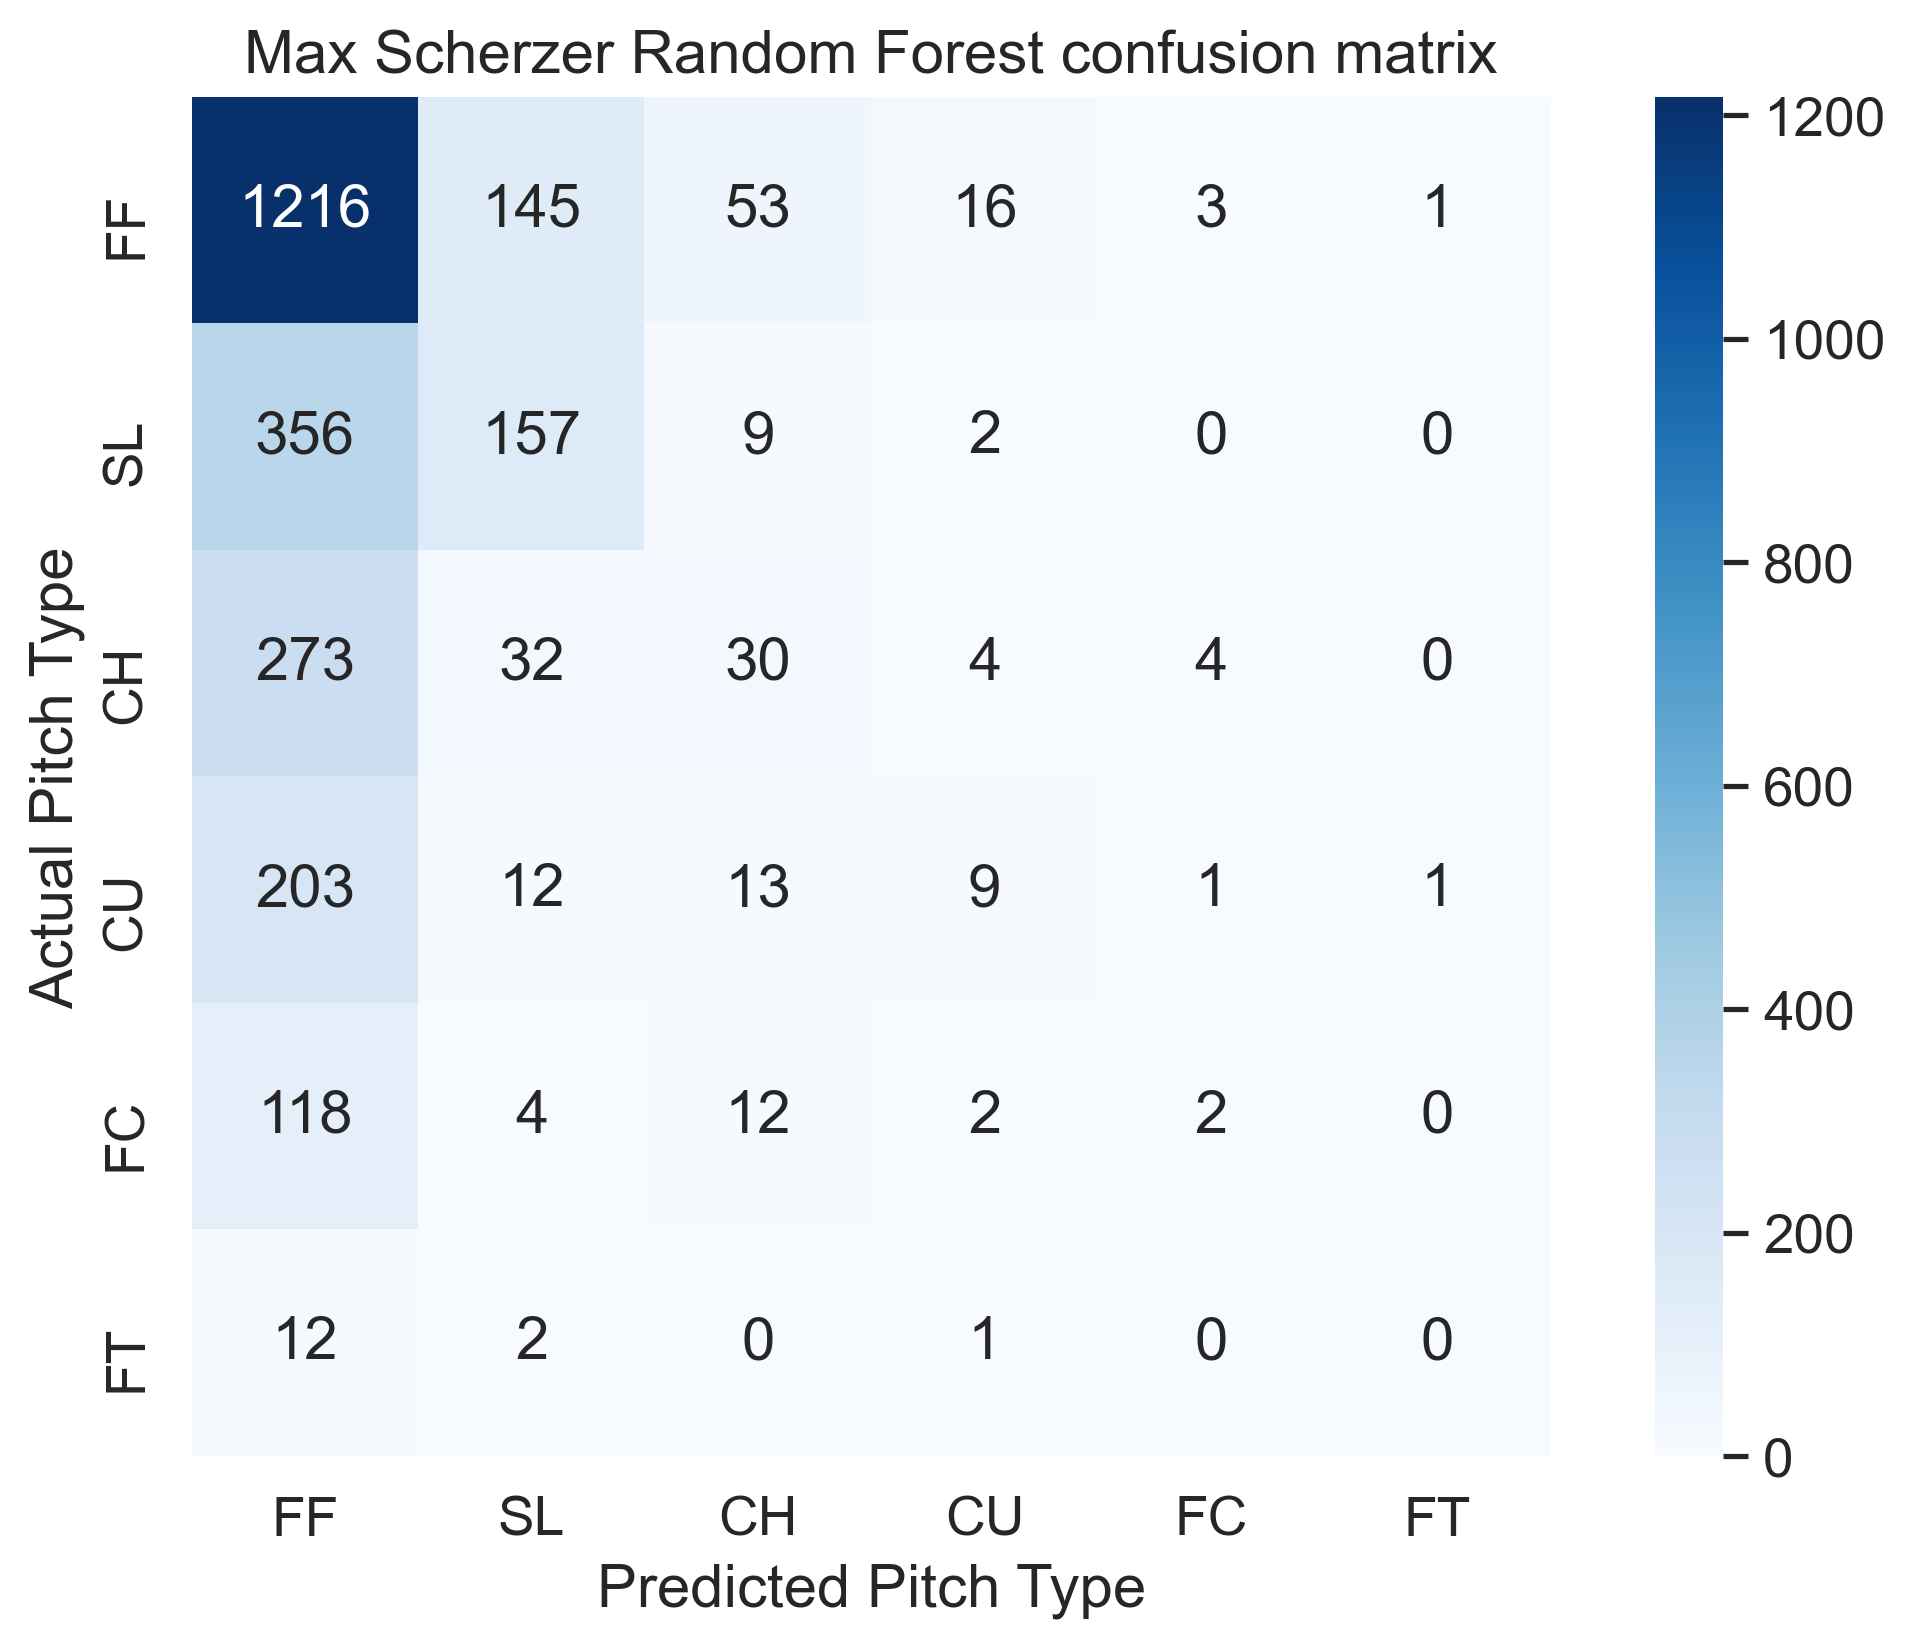

In [33]:
model = random_forest_eval_kfold('Max Scherzer',X,y, model_df,k=5)

The model is doing it's best with four seam fastballs, which is good since that is the most commonly thrown pitch as shown in my EDA.  It is struggling (on the surface) with other pitch types, though.  I am hopeful that adding in the running rates of these pitchers that each pitcher throws will help with that.

For now, I am not going to mess with the hyperparameters of Random Forest until I see how that is going to turn out.

In the meantime, I'll test out the pipeline I've developed with some of the other pitchers in the dataset.

### RA Dickey

RA Dickey was a very heavy knuckleball pitcher.  I am curious to see how it works with him.

In [34]:
dickey_df = train_df[train_df.pitcher_full_name == 'R.A. Dickey']

In [35]:
new_df = column_ohe_maker(dickey_df, ohe_cols)

In [36]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
output_df.pitch_type.value_counts()

KN    7461
FF    1194
EP     203
Name: pitch_type, dtype: int64

In [38]:
output_df.Pitch_Type_Num.value_counts()

0    7461
1    1194
2     203
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [39]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None', 'Pitch_Type_Num'],
      dtype='object')

In [40]:
model_df = output_df[output_df.last_pitch_px.notnull()]

In [41]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None']

In [42]:
X = model_df[col]

In [43]:
y = model_df['Pitch_Type_Num']

Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1473   23    0]
 [ 205   31    0]
 [  38    0    0]]


Confusion Matrix for Fold 2
[[1465   28    0]
 [ 206   31    0]
 [  40    0    0]]


Confusion Matrix for Fold 3
[[1439   29    0]
 [ 220   38    0]
 [  44    0    0]]


Confusion Matrix for Fold 4
[[1453   27    0]
 [ 212   32    0]
 [  46    0    0]]


Confusion Matrix for Fold 5
[[1492   25    0]
 [ 193   25    0]
 [  35    0    0]]




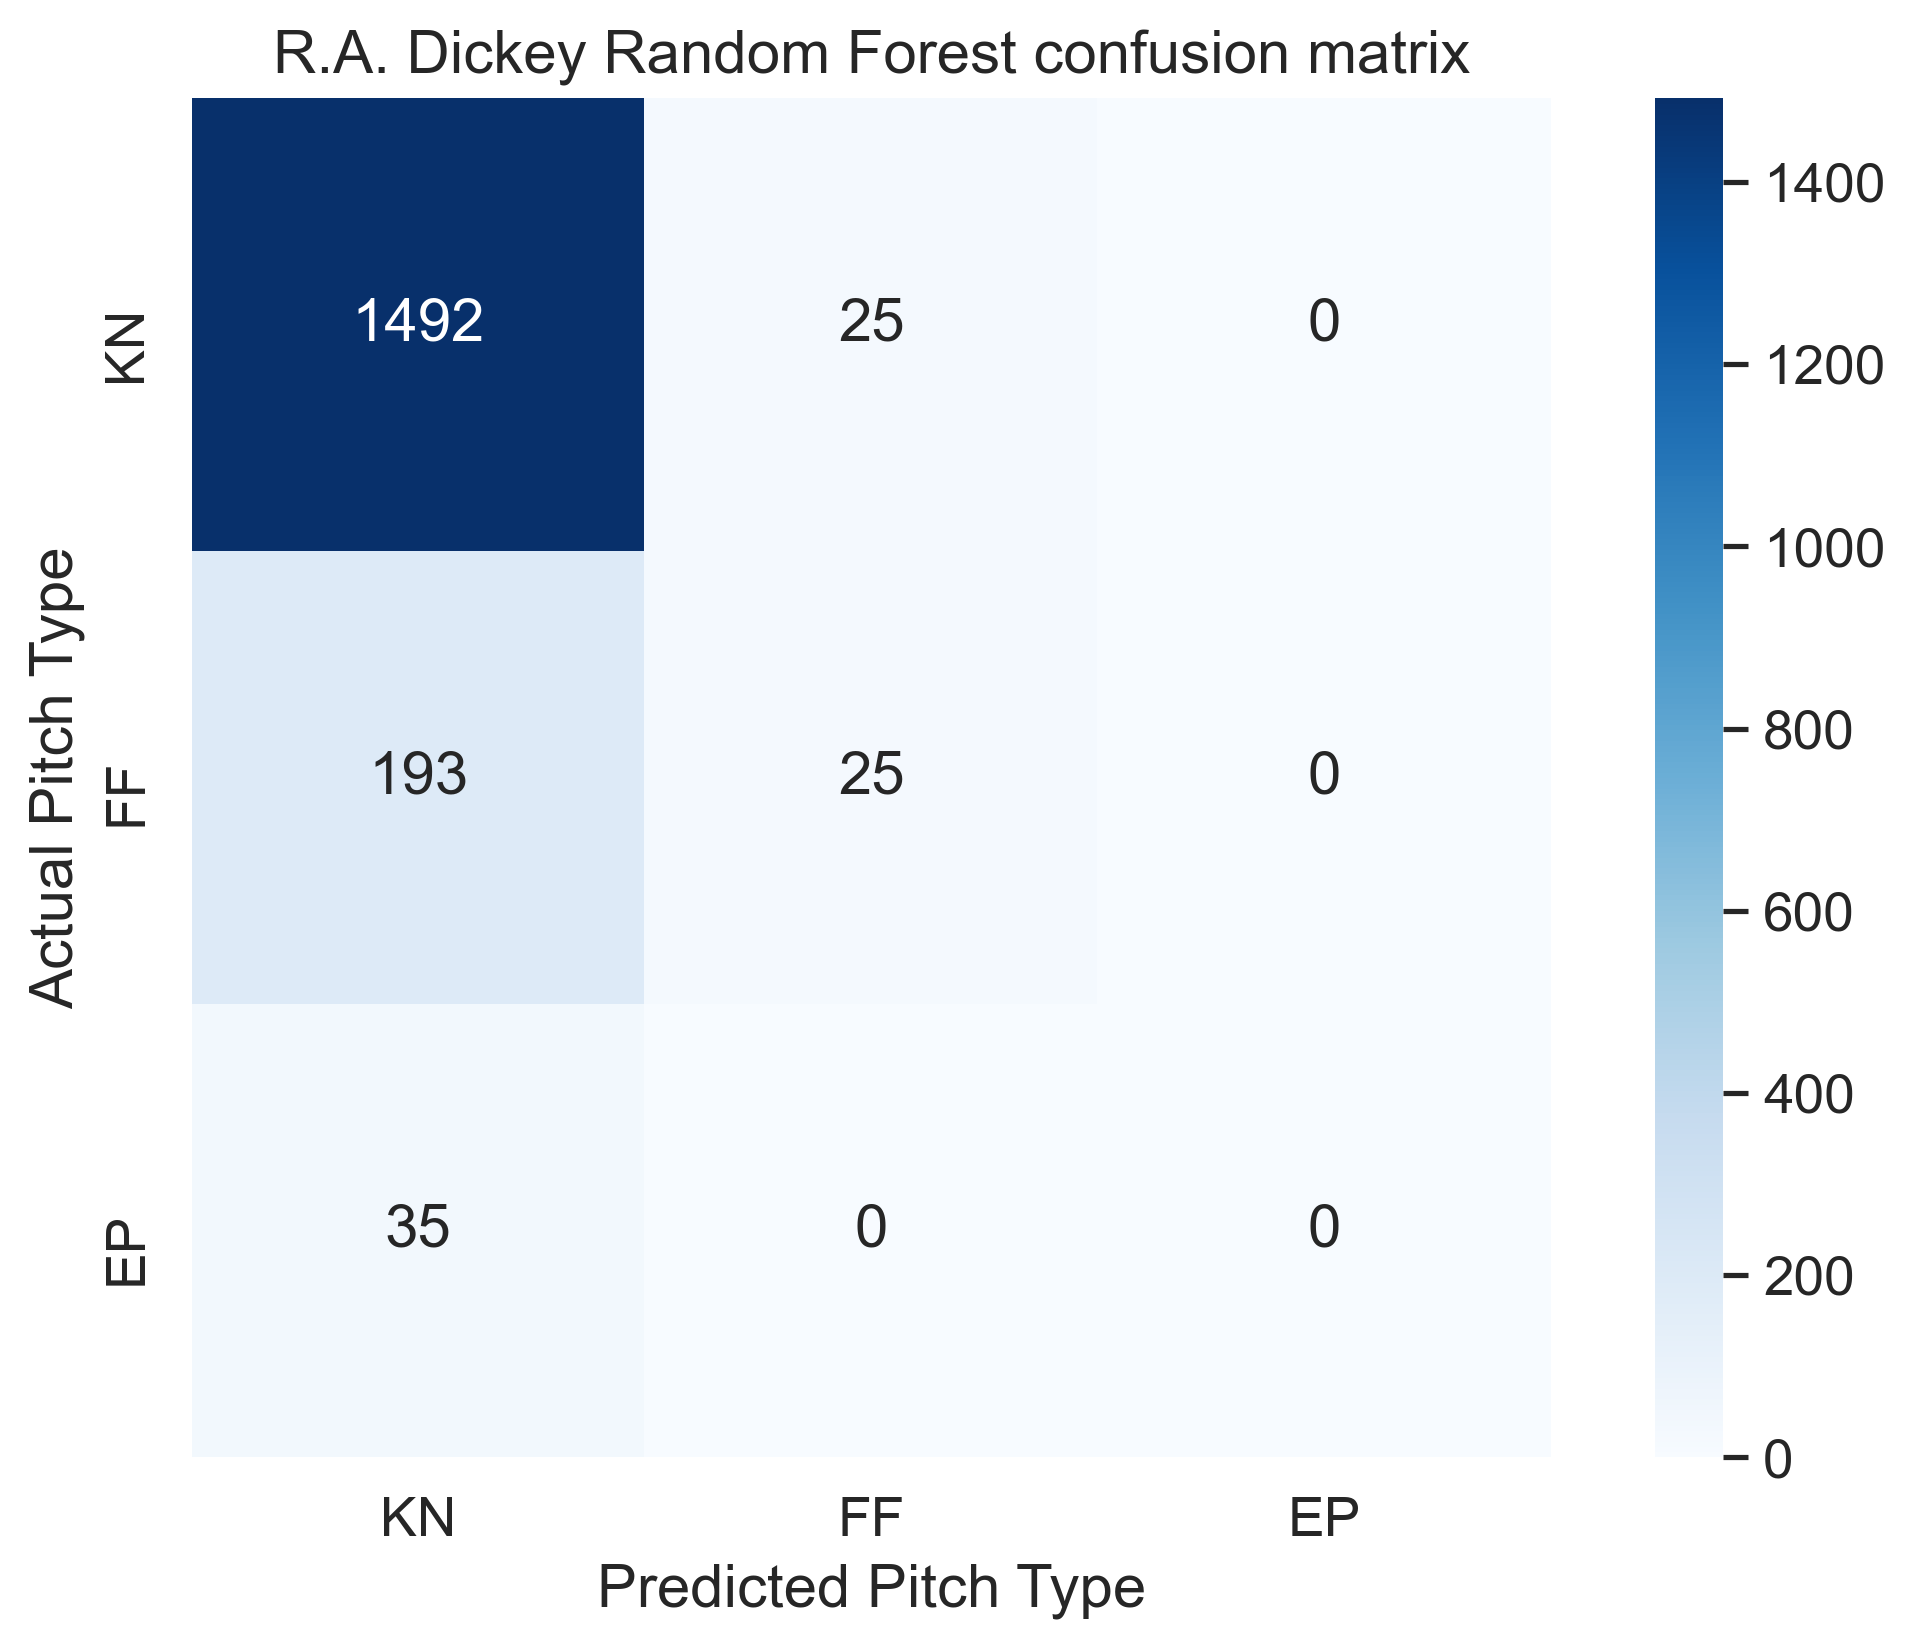

In [44]:
model = random_forest_eval_kfold('R.A. Dickey',X,y, model_df,k=5)

Overall, again it is good with the knuckleball, his primary pitch.  The Four seamer isn't as great as I'd like.  I'm not really concerned with Eephus (EP), as that is a trick pitch where the pitcher throws it in super slow.

### Yu Darvish

Darvish will be another challenge case, as he throws a wide range of pitches.

In [45]:
darvish_df = train_df[(train_df.pitcher_full_name == 'Yu Darvish') & (train_df.last_pitch_pz.notnull())]

In [46]:
new_df = column_ohe_maker(darvish_df, ohe_cols)

In [47]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'FC': 3, 'CU': 4, 'CH': 5, 'FS': 6, 'EP': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
output_df.pitch_type.value_counts()

FF    1964
SL    1257
FT     965
FC     684
CU     328
CH     104
FS      37
EP       5
Name: pitch_type, dtype: int64

In [49]:
output_df.Pitch_Type_Num.value_counts()

0    1964
1    1257
2     965
3     684
4     328
5     104
6      37
7       5
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [50]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_EP', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'Pitch_Type_Num'],
      dtype='object')

In [51]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_speed', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_type_CU', 'last_pitch_type_EP', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_SL']

In [52]:
X = output_df[col]

In [53]:
y = output_df['Pitch_Type_Num']

Random Forest Results for Yu Darvish
Confusion Matrix for Fold 1
[[237  83  48  22   5   0   1   0]
 [111  81  37  13   3   0   1   0]
 [ 97  36  45  13   1   0   0   0]
 [ 69  27  23  16   1   0   0   0]
 [ 30  21   7   4   5   0   0   0]
 [ 17   5   2   2   2   0   0   0]
 [  1   1   0   1   0   0   0   0]
 [  0   1   0   0   0   0   0   0]]


Confusion Matrix for Fold 2
[[248  69  38  15   6   0   0]
 [160  81  21   8   5   0   0]
 [ 97  26  43   8   0   0   1]
 [ 76  26  19  21   1   0   0]
 [ 37  21   6   6   5   0   0]
 [ 11   4   1   1   0   1   0]
 [  3   2   1   1   0   0   0]]


Confusion Matrix for Fold 3
[[251  66  39  15   3   0   1   0]
 [133  95  24  12   6   0   0   0]
 [ 76  38  59  12   0   1   0   0]
 [ 75  25  12  25   0   0   0   0]
 [ 37  23   3   1   2   0   0   0]
 [ 11   7   1   1   0   0   0   0]
 [  8   4   0   0   1   0   0   0]
 [  1   0   0   0   1   0   0   0]]


Confusion Matrix for Fold 4
[[255  75  33  20   3   0   0]
 [114  79  24  17   2   0   0]
 [1

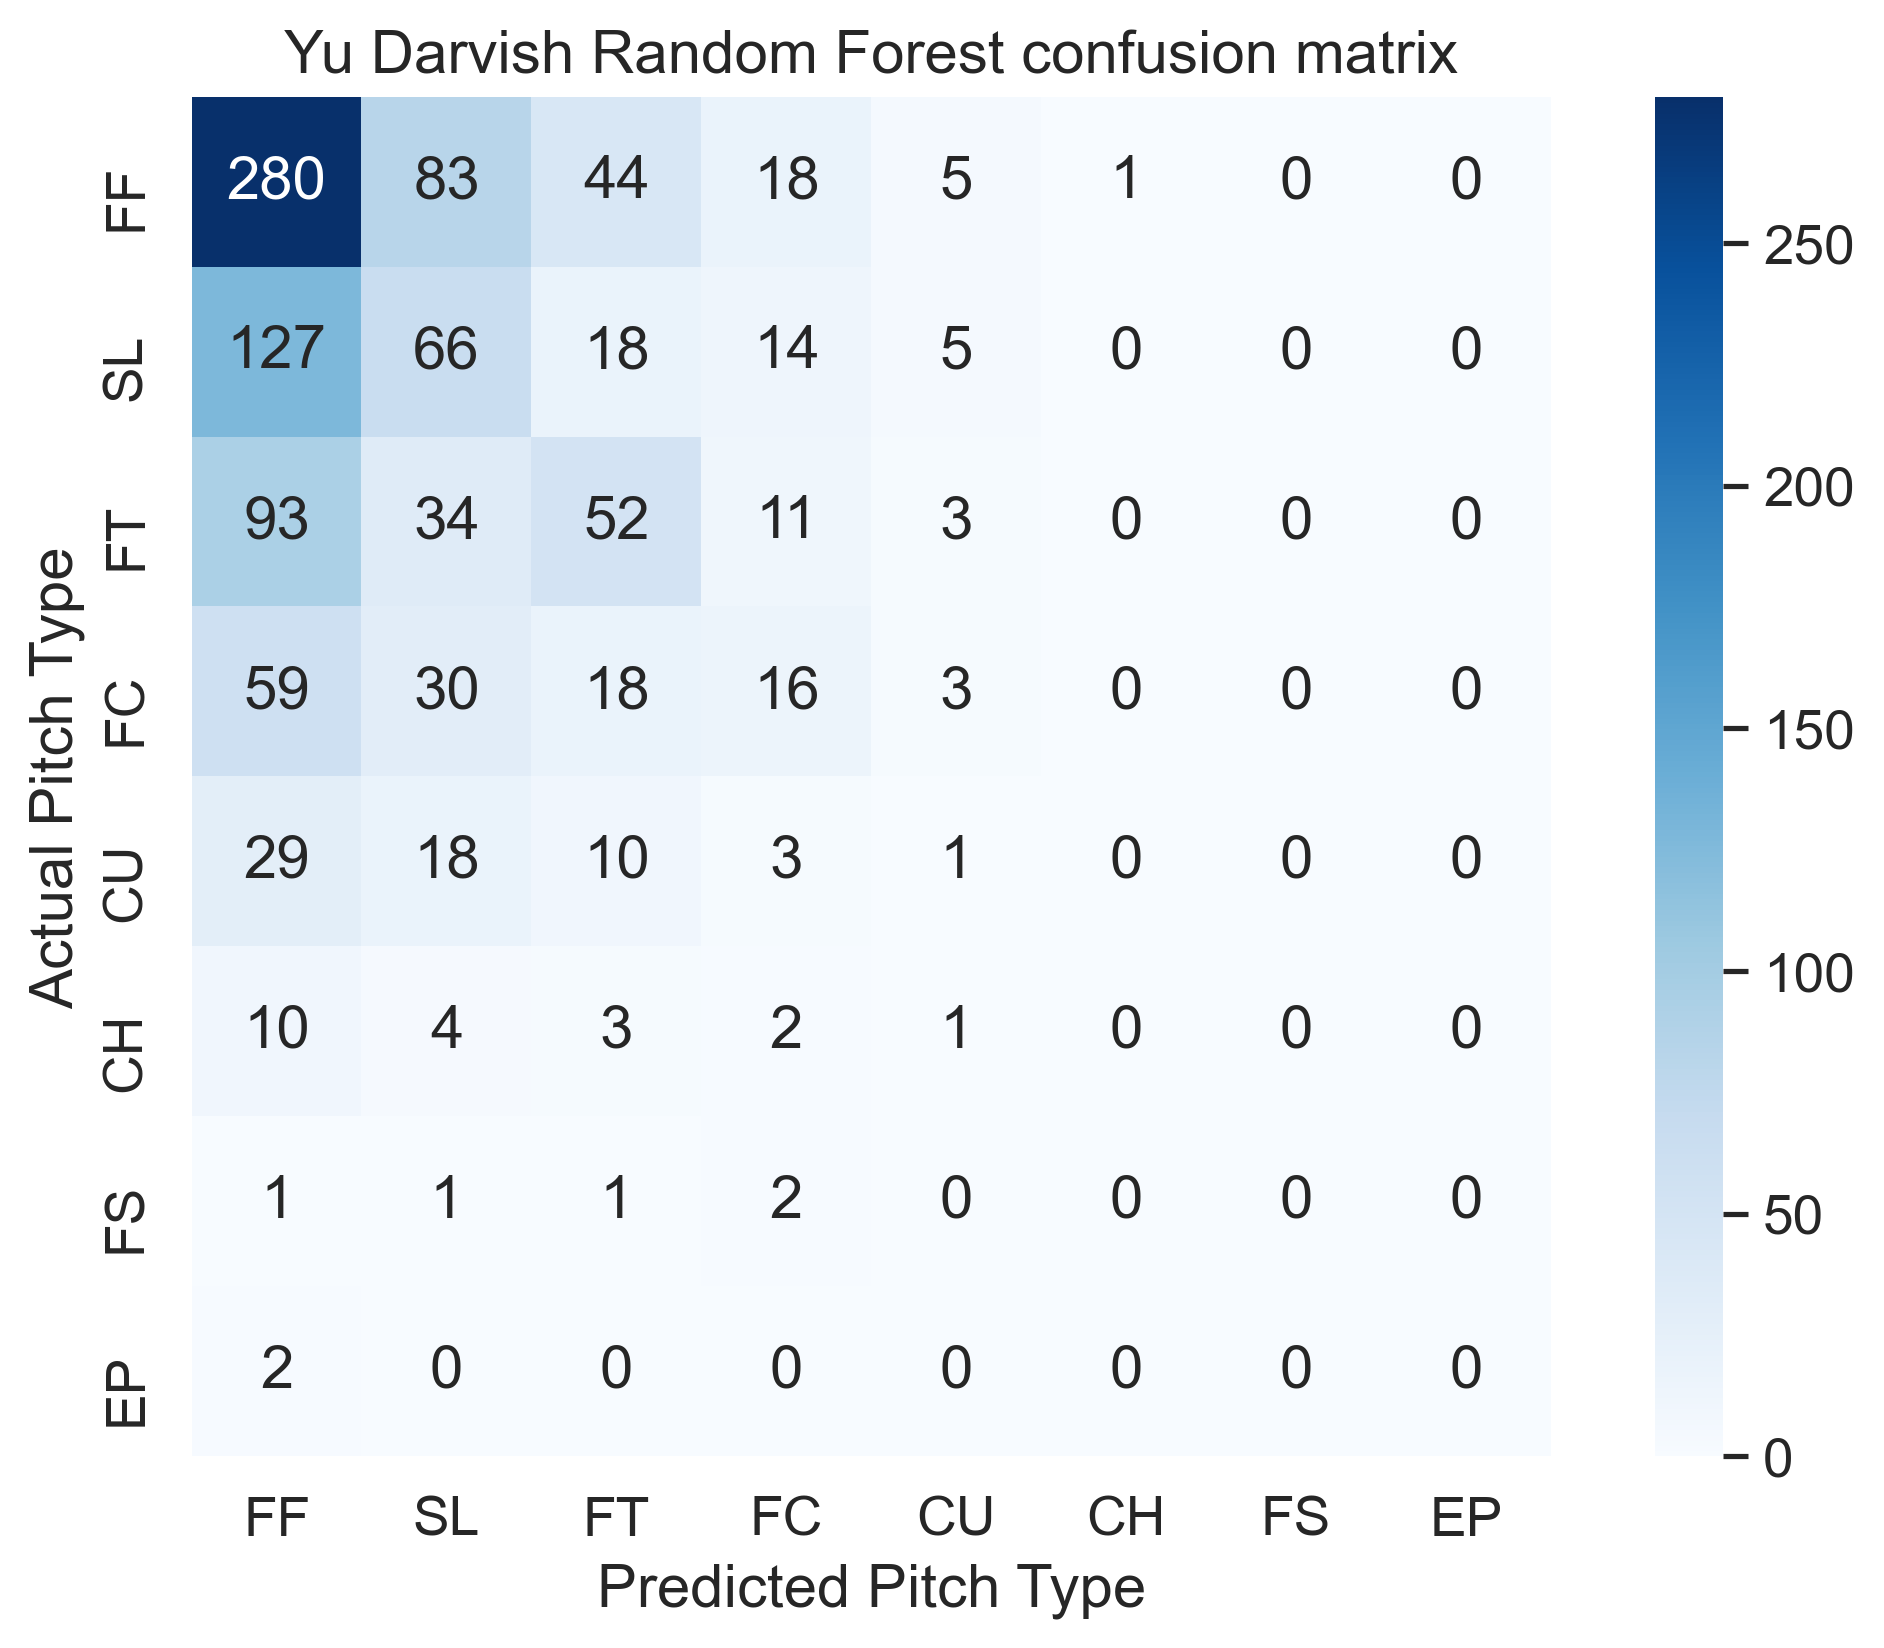

In [54]:
model = random_forest_eval_kfold('Yu Darvish',X,y, output_df,k=5)

The model definitely challenges with Yu Darvish here.  This makes sense, since he throws so many types of pitches.  Once I have the pitch proportions this should improve in performance.

### Alex Colome

I am going to try with Colome, who is a reliever who heavily focuses on his cut fastball.

In [55]:
colome_df = train_df[(train_df.pitcher_full_name == 'Alex Colome') & (train_df.last_pitch_px.notnull())]

In [56]:
new_df = column_ohe_maker(colome_df, ohe_cols)

In [57]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'CU': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [58]:
output_df.pitch_type.value_counts()

FF    2164
FC    2010
CH     295
CU     112
FT      55
Name: pitch_type, dtype: int64

In [59]:
output_df.Pitch_Type_Num.value_counts()

0    2164
1    2010
2     295
3     112
4      55
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [60]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'Pitch_Type_Num'],
      dtype='object')

In [61]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT']

In [62]:
X = output_df[col]

In [63]:
y = output_df['Pitch_Type_Num']

Random Forest Results for Alex Colome
Confusion Matrix for Fold 1
[[298 142   8   0   0]
 [109 283   2   0   0]
 [ 42  13   3   0   0]
 [  7   7   0   0   0]
 [ 10   3   1   0   0]]


Confusion Matrix for Fold 2
[[280 121   5   1   0]
 [137 284   2   0   0]
 [ 39  11   6   0   1]
 [ 19   5   1   1   0]
 [ 10   2   2   0   0]]


Confusion Matrix for Fold 3
[[308 122   6   2   2]
 [116 266   8   0   0]
 [ 38  24   4   0   0]
 [ 13   8   1   0   0]
 [  7   2   0   0   0]]


Confusion Matrix for Fold 4
[[312 122   5   0   1]
 [137 255   1   0   0]
 [ 38  17   4   0   0]
 [ 18   5   0   0   0]
 [ 10   1   1   0   0]]


Confusion Matrix for Fold 5
[[302 123   3   1   0]
 [133 276   1   0   0]
 [ 35  13   7   0   0]
 [ 16  11   0   0   0]
 [  4   2   0   0   0]]




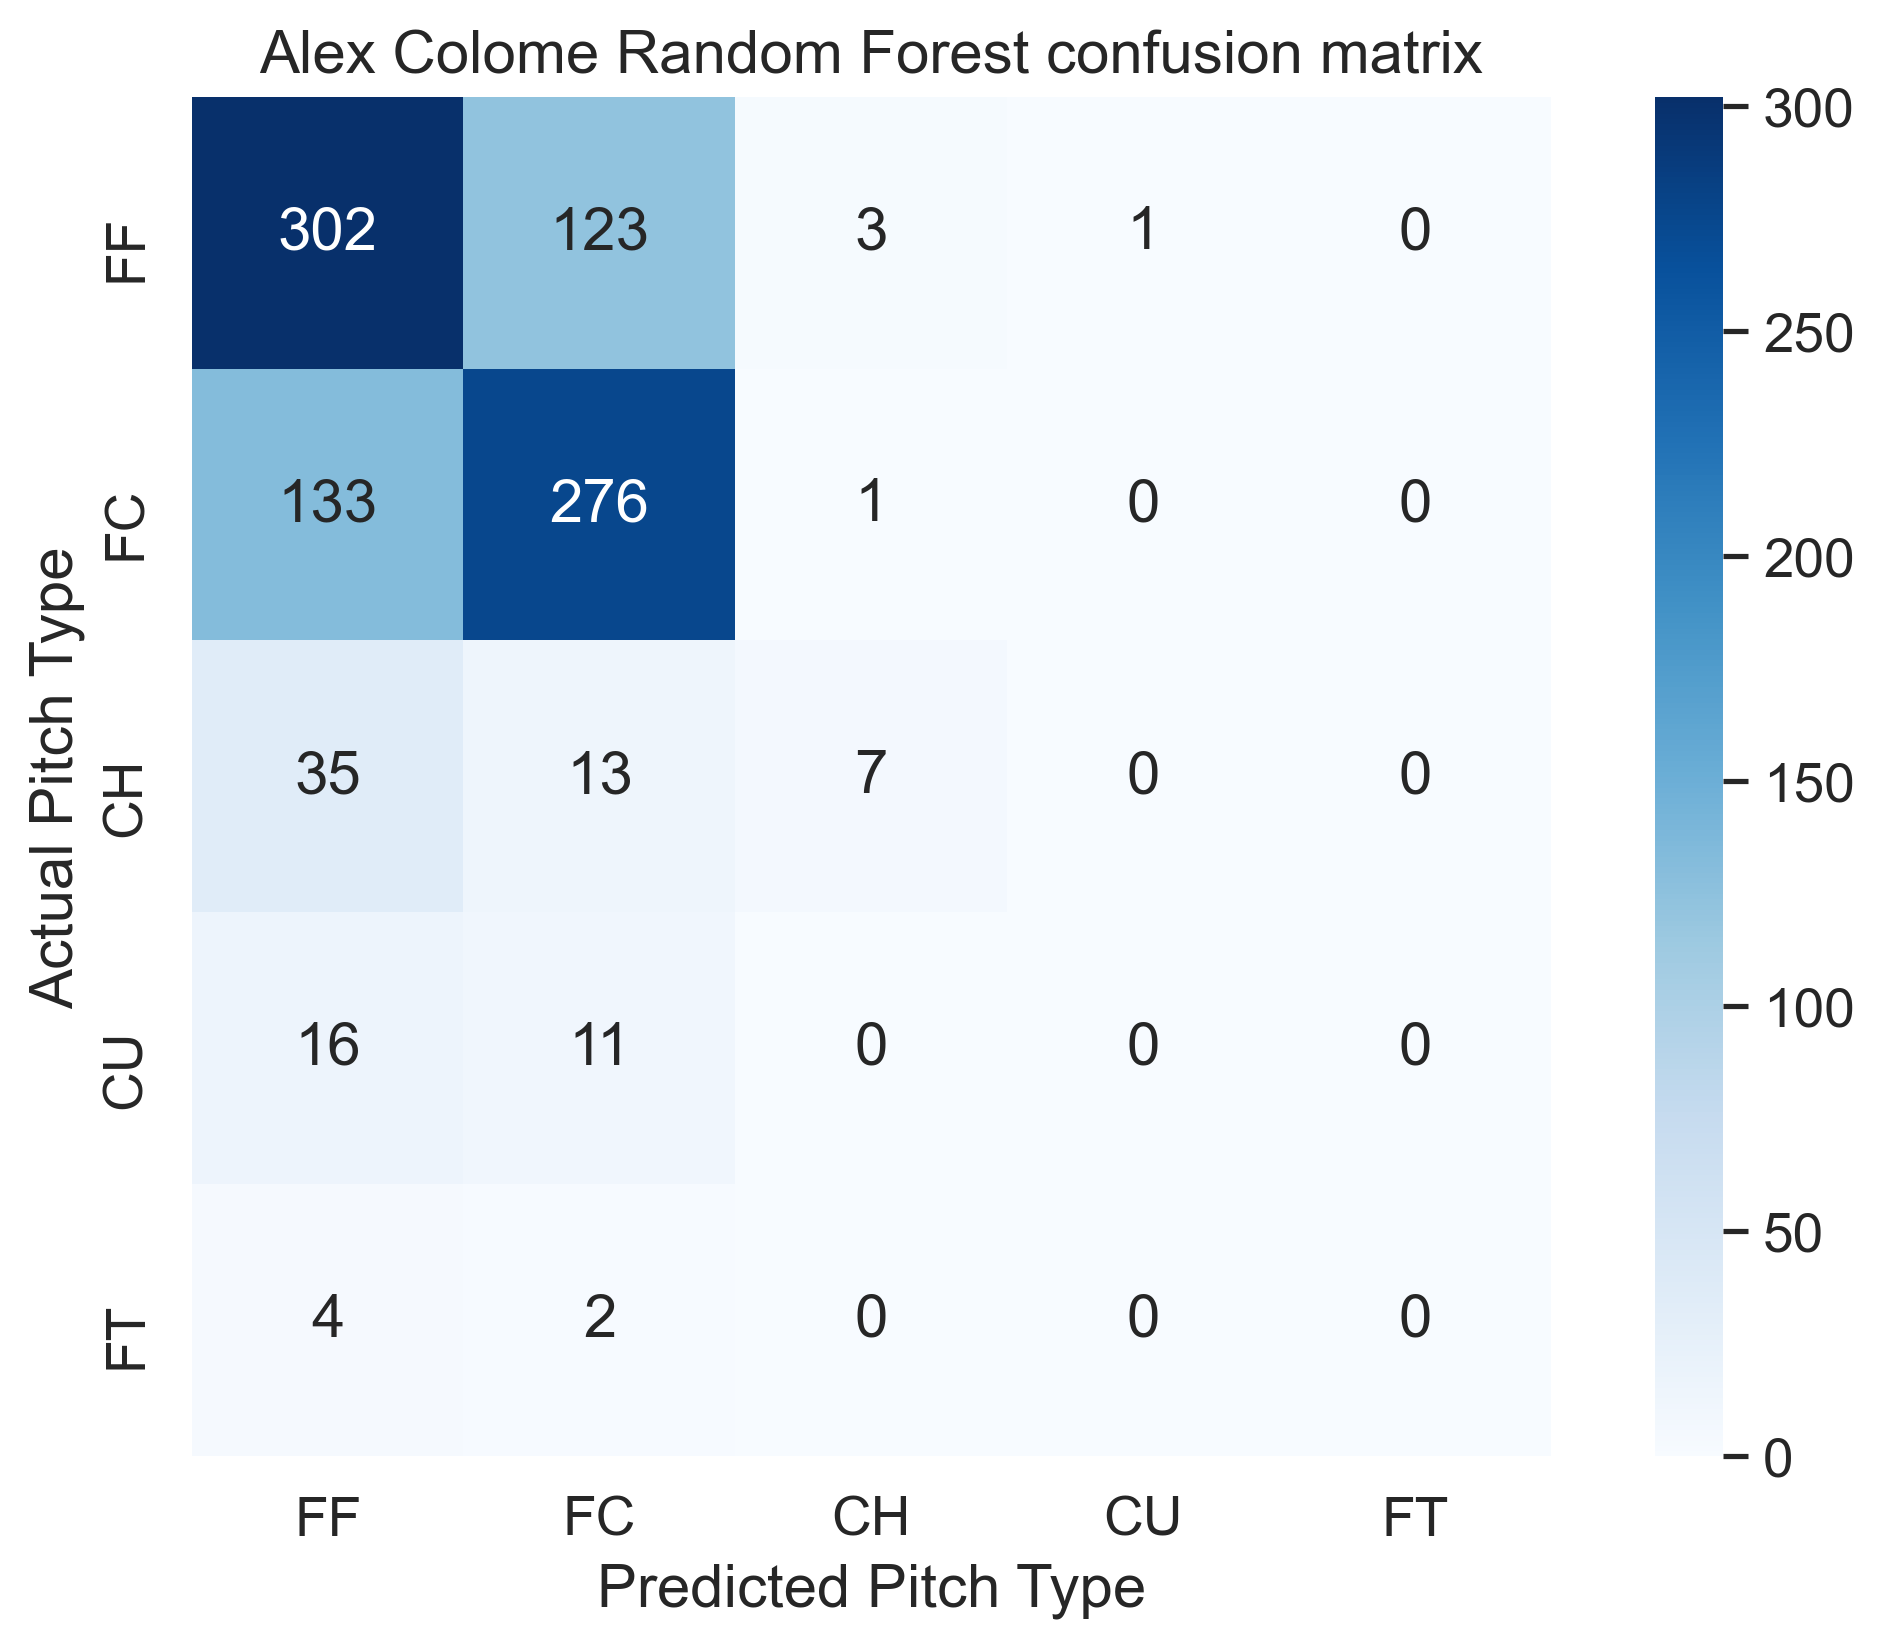

In [64]:
model = random_forest_eval_kfold('Alex Colome',X,y, output_df,k=5)

Overall, this has decent performance on the four-seamer and cutter, which are his primary pitches.  Based on what I am seeing so far, the model is doing a good job with the higher usage pitches, and struggling with lesser-used ones. 


Next, to hopefully help address that, I'll be bringing in my running pitch arsenal proportions that was created in modeling_prep.ipynb.

# Adding Pitch Proportions

In [65]:
with open('../Data/full_pitch_df.pickle','rb') as read_file:
    arsenal_df = pickle.load(read_file)

In [66]:
arsenal_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc',
       'cumulative_pitches'],
      dtype='object')

In [67]:
arsenal_df[arsenal_df.Season != 2019].tail(15)

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_cu,cumulative_si,cumulative_fc,cumulative_kc,cumulative_fs,cumulative_kn,cumulative_ep,cumulative_fo,cumulative_sc,cumulative_pitches
2848356,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,0,0,0,0,0,0,0,0,0,2076
2848357,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,0,0,0,0,0,0,0,0,0,2077
2848358,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2078
2848359,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2079
2848360,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2080
2848361,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2081
2848362,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2082
2848363,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2083
2848364,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2084
2848365,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2085


In [68]:
train_df.tail(15)

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,pitch_num,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season
2848356,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,3.0,FF,1.064241,3.907686,97.8,Josh Hader,2.0,Ben Zobrist,2018-10-01,2018
2848357,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,4.0,SL,0.676805,3.487355,83.0,Josh Hader,2.0,Ben Zobrist,2018-10-01,2018
2848358,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,1.0,FF,-0.272231,2.628069,97.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848359,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,2.0,SL,-0.107080,0.886212,84.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848360,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,3.0,FF,0.239849,1.343620,96.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848361,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,4.0,FF,1.735599,3.282581,95.5,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848362,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,5.0,FF,0.404748,2.917373,96.2,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848363,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,6.0,FF,0.084721,1.523047,96.4,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848364,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,7.0,FF,-0.599352,1.981704,97.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848365,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,8.0,FF,0.500757,2.783971,97.0,Josh Hader,2.0,Javier Baez,2018-10-01,2018


The indices luckily look identical, which is helpful in merging

Before merging, I want to convert the arsenal_df running counts to rates, so I have a "live" proportion of what pitch types that pitcher has thrown.

In [69]:
pitch_count_columns = ['cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc']

In [70]:
total_pitches = arsenal_df['cumulative_pitches']
for i, column in enumerate(pitch_count_columns):
    counts = arsenal_df[column]
    rate_name = column + '_' + 'rate'
    arsenal_df[rate_name] = counts / total_pitches
    
#Setting NaN's (i.e. all pitchers first pitches) to 0 for each pitch
for i, pitch_num in enumerate(arsenal_df['cumulative_pitches']):
    if pitch_num == 0:
        arsenal_df.iloc[i, 48:] = 0

In [71]:
arsenal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555834 entries, 0 to 3555833
Data columns (total 61 columns):
 #   Column              Dtype         
---  ------              -----         
 0   inning              float64       
 1   batter_id           int64         
 2   pitcher_id          int64         
 3   top                 float64       
 4   ab_id               float64       
 5   p_score             float64       
 6   stand               object        
 7   p_throws            object        
 8   event               object        
 9   home_team           object        
 10  away_team           object        
 11  b_score             float64       
 12  on_1b               float64       
 13  on_2b               float64       
 14  on_3b               float64       
 15  px                  float64       
 16  pz                  float64       
 17  zone                object        
 18  pitch_type          object        
 19  start_speed         float64       
 20  ty

In [72]:
arsenal_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc', 'cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate

In [73]:
arsenal_df.iloc[:, 47:].head(10)

,cumulative_pitches,cumulative_ff_rate,cumulative_sl_rate,cumulative_ft_rate,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.800000,0.0,0.0,0.0,0.200000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.833333,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.857143,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,8,0.750000,0.0,0.0,0.0,0.125000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.777778,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


Excellent, this is now ready to merge.

In [74]:
arsenal_df.drop(columns=['cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc'], inplace=True)

In [75]:
arsenal_df[arsenal_df.Season != 2019].shape

(2848371, 48)

In [76]:
train_df.shape

(2848371, 34)

In [77]:
merge_cols = ['cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate']

In [78]:
joined_train_df = train_df.merge(arsenal_df[arsenal_df.Season != 2019][merge_cols], how='left', left_index=True, right_index=True)

Pickling out this dataframe:

# Modeling w/ Updated DF:

### RA Dickey:

I'll start by testing with R.A. Dickey, utilizing the random_forest_pitch_pipeline function from pitch_cat_functions.py:

In [79]:
joined_train_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate'],
      dtype='object')

In [80]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None', 'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1481   15    0]
 [ 211   25    0]
 [  38    0    0]]


Confusion Matrix for Fold 2
[[1464   29    0]
 [ 208   29    0]
 [  40    0    0]]


Confusion Matrix for Fold 3
[[1453   15    0]
 [ 240   18    0]
 [  44    0    0]]


Confusion Matrix for Fold 4
[[1461   19    0]
 [ 213   31    0]
 [  46    0    0]]


Confusion Matrix for Fold 5
[[1498   19    0]
 [ 187   31    0]
 [  35    0    0]]




RandomForestClassifier()

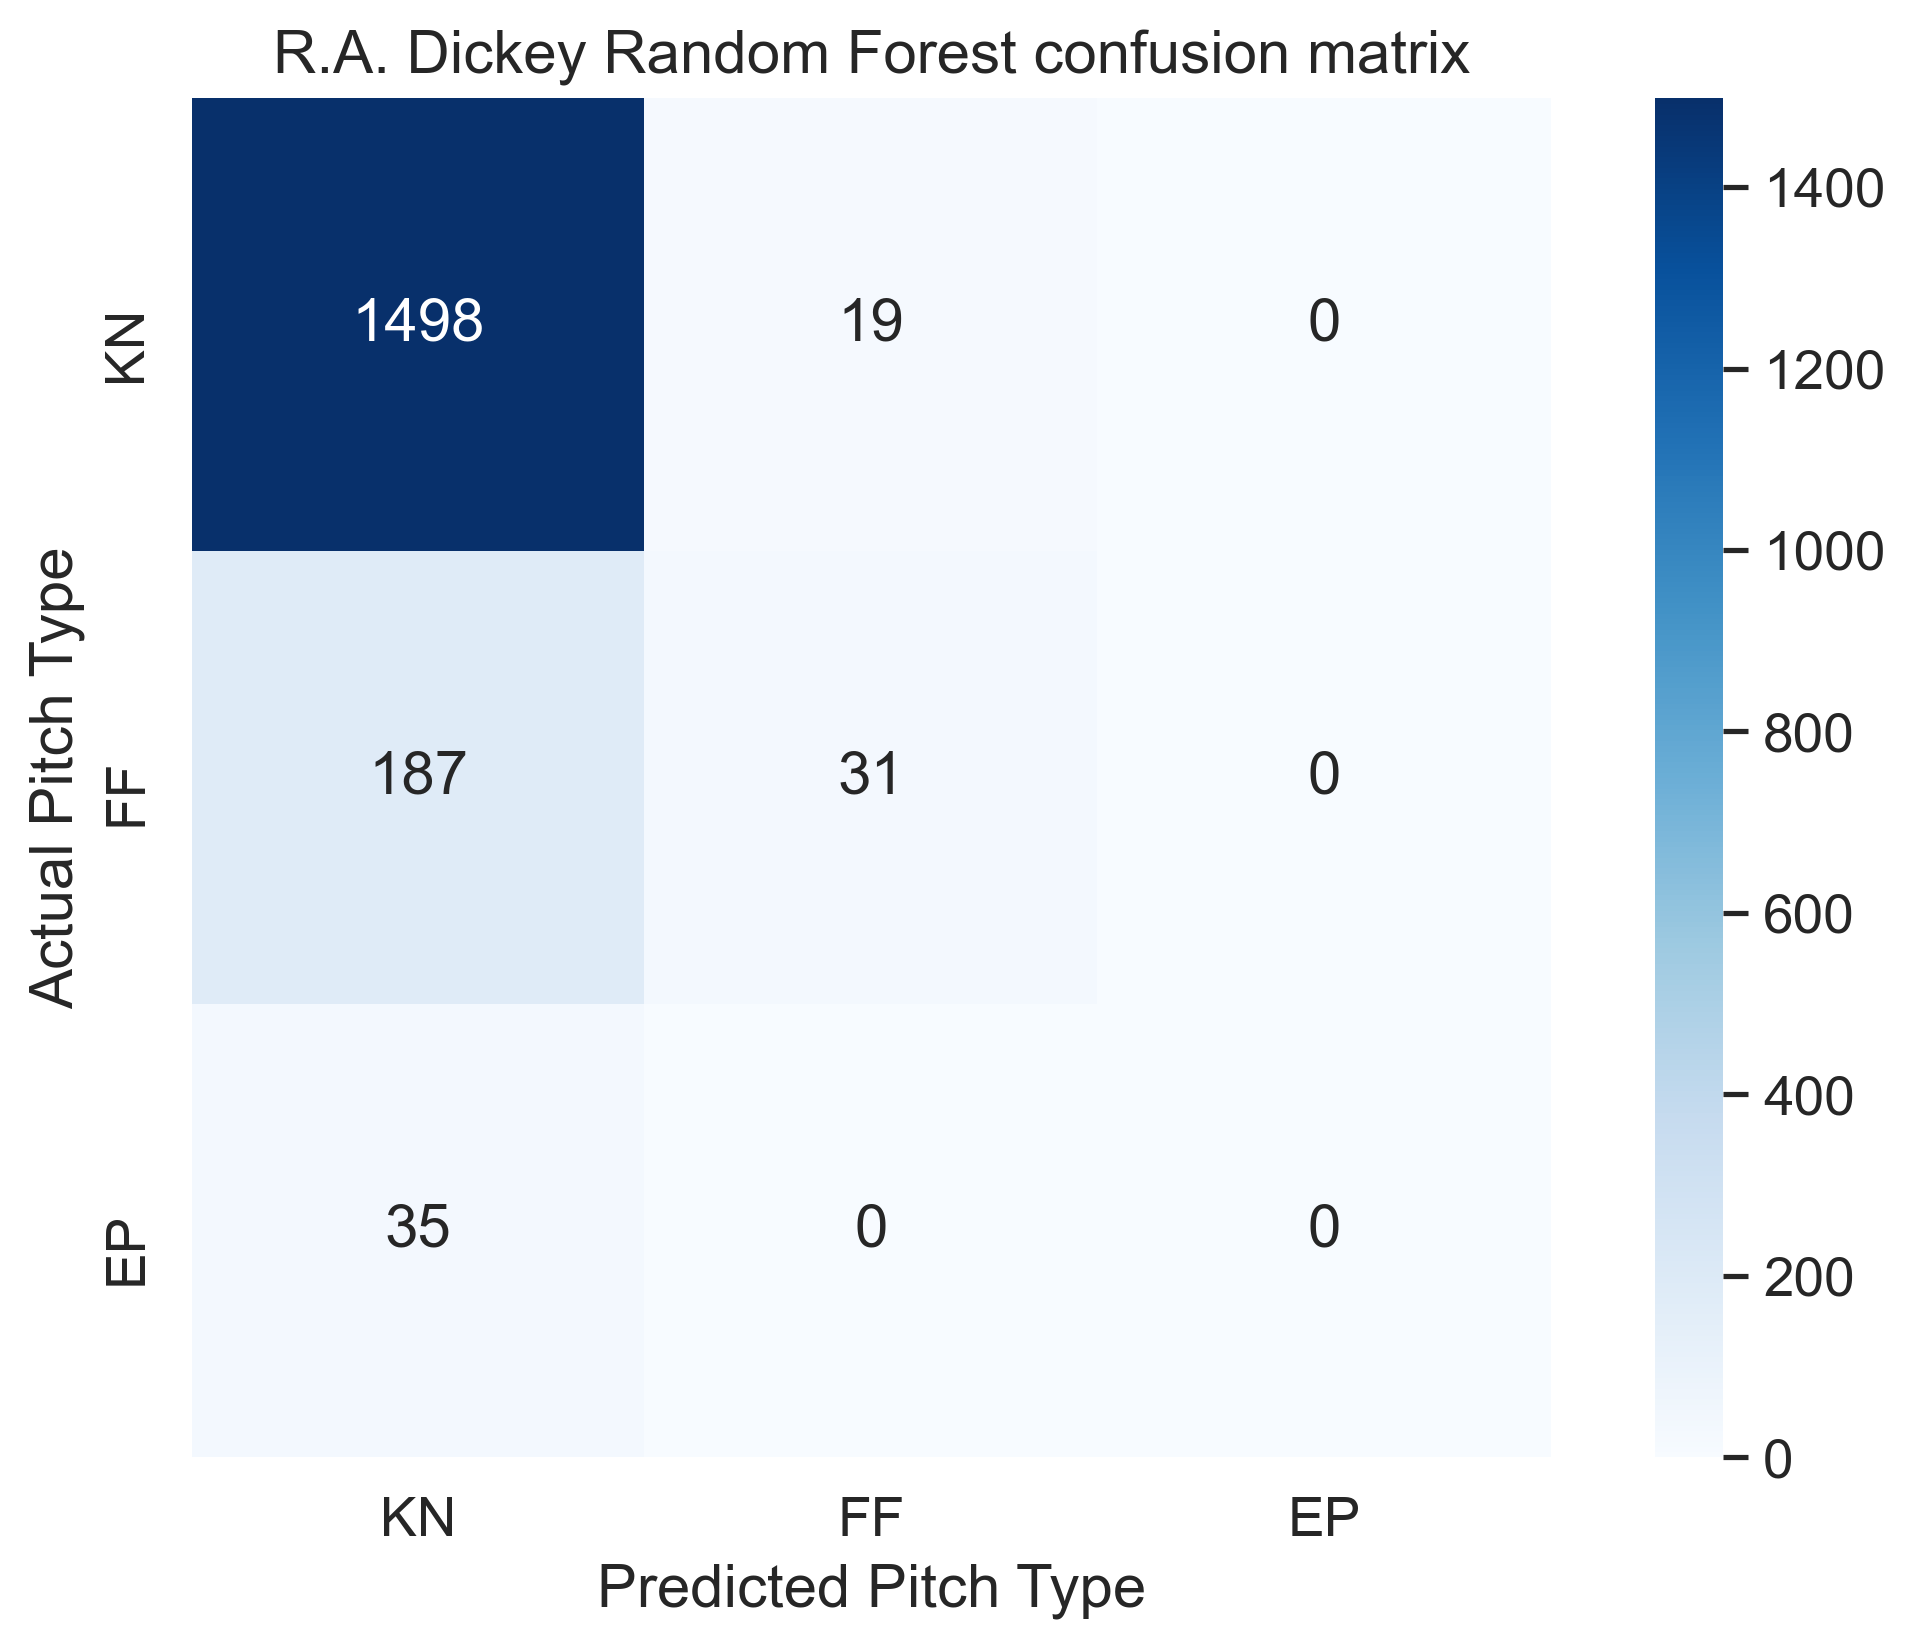

In [81]:
random_forest_pitch_pipeline('R.A. Dickey', joined_train_df, ohe_cols, col, k=5)

### Max Scherzer:

Next test with Max Scherzer:

In [82]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[1181  137   48   11   14    0]
 [ 406  141   10    1    2    1]
 [ 314   22   13    2   13    0]
 [ 190    4    8    6    3    0]
 [ 131    0    9    2    3    0]
 [  12    7    1    1    1    0]]


Confusion Matrix for Fold 2
[[1191  182   42   19    9    0]
 [ 334  141    8    2    0    0]
 [ 312   52   25    4    7    1]
 [ 179    9    6    5    2    2]
 [ 121    2   12    0    4    0]
 [  17    5    0    0    0    0]]


Confusion Matrix for Fold 3
[[1199  159   38   17   14    1]
 [ 337  151   16    4    0    2]
 [ 314   25   28    3    3    1]
 [ 201    5   10   10    3    0]
 [ 117    2    9    0    7    0]
 [   8    8    1    0    0    0]]


Confusion Matrix for Fold 4
[[1168  170   43   18   14    2]
 [ 431  116    9    1    0    0]
 [ 304   31   23    7    4    1]
 [ 178    9    9    5    5    1]
 [ 117    3    6    1    4    0]
 [   6    4    1    0    0    2]]


Confusion Matrix for Fold 5
[[1198  141   56 

RandomForestClassifier()

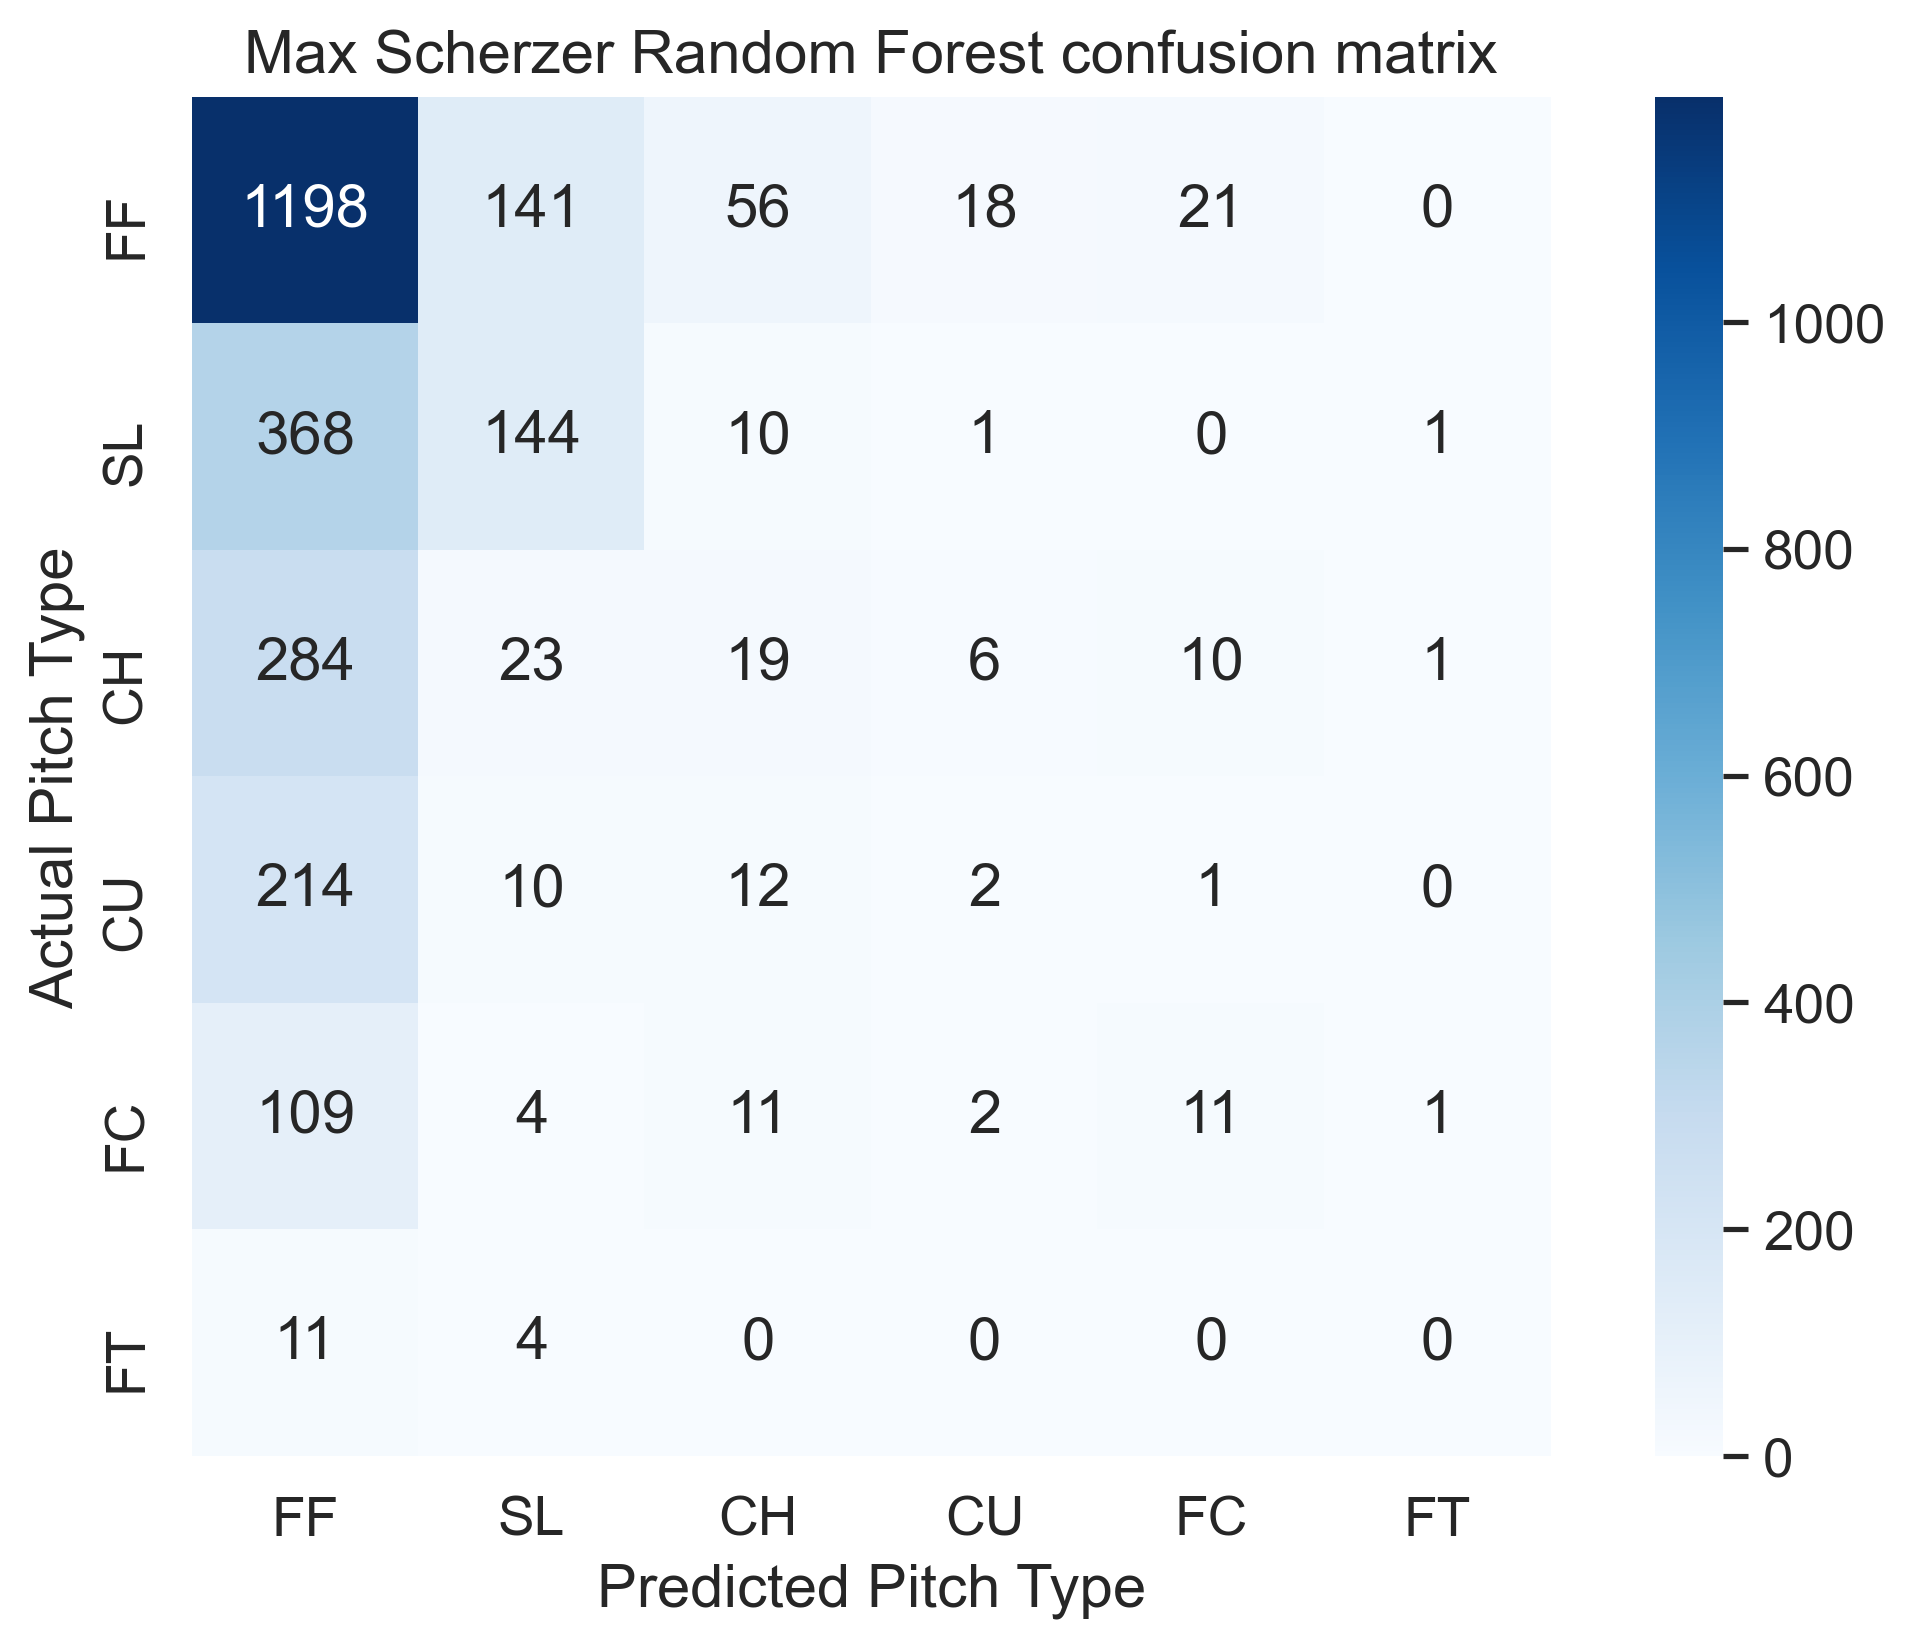

In [83]:
random_forest_pitch_pipeline('Max Scherzer', joined_train_df, ohe_cols, col, k=5)

Overall, it is performing well on the pitcher's primary pitch, but not as much on the lesser-thrown pitches.

## Batter Clusters:

One other feature I was looking to bring on was the hitter clusters from notebook Batter_Clustering in the Clustering folder.  I'll test that out here:

Plickling in the clusters:

In [84]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [85]:
with open('../Data/batter_clusters/cluster_assignments.pickle','rb') as read_file:
    clusters_df = pickle.load(read_file)

In [86]:
train_df_clusters = joined_train_df.merge(clusters_df, how='left', left_on='hitter_full_name', right_on='Name')

In [87]:
train_df_clusters.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate,Name,Cluster
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0


In [88]:
train_df_clusters.isnull().sum()

inning                    0
batter_id                 0
pitcher_id                0
top                       0
ab_id                     0
p_score                   0
stand                     0
p_throws                  0
event                     0
home_team                 0
away_team                 0
b_score                   0
on_1b                     0
on_2b                     0
on_3b                     0
px                        0
pz                        0
zone                      0
pitch_type                0
start_speed               0
type                      0
b_count                   0
s_count                   0
outs                      0
pitch_num                 0
last_pitch_type        3267
last_pitch_px          3267
last_pitch_pz          3267
last_pitch_speed       3249
pitcher_full_name         0
pitcher_run_diff          0
hitter_full_name          0
Date_Time_Date            0
Season                    0
cumulative_pitches        0
cumulative_ff_rate  

For all the players who weren't assigned a cluster, that is because they did not have 100 plate appearances.  Thus, they likely do not have enough PA's to have a distinct track record, so I will assign them to cluster 4.0, as a placeholder to not lose the rows.

In [89]:
train_df_clusters.Cluster.value_counts()

3.0    1136562
0.0    1010923
1.0     599491
2.0      40118
Name: Cluster, dtype: int64

In [90]:
train_df_clusters.Cluster.fillna(value=4.0, inplace=True)

In [91]:
train_df_clusters.Cluster.value_counts()

3.0    1136562
0.0    1010923
1.0     599491
4.0      83278
2.0      40118
Name: Cluster, dtype: int64

Pickling out this dataframe:

In [92]:
with open('../Data/train_df_clusters.pickle', 'wb') as to_write:
    pickle.dump(train_df_clusters, to_write)

Now, going into modeling.

### Max Scherzer:

Next test with Max Scherzer:

In [93]:
col = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[1223  150   41   20   11    1]
 [ 375  150    7    1    2    1]
 [ 317   28   16    6    7    1]
 [ 179    7    4    4    0    0]
 [ 126    2   14    2    7    0]
 [  10    9    0    1    1    0]]


Confusion Matrix for Fold 2
[[1169  172   33   21   14    1]
 [ 368  148    9    1    0    2]
 [ 332   36   21    3    6    0]
 [ 204    4   11    5    5    0]
 [ 116    2   11    1    9    0]
 [  14    2    1    2    0    0]]


Confusion Matrix for Fold 3
[[1228  157   44   17   15    0]
 [ 354  158    7    2    0    1]
 [ 312   39   32    4    8    0]
 [ 182    4    8    7    0    2]
 [  96    3    9    2    9    0]
 [  14    9    0    0    0    0]]


Confusion Matrix for Fold 4
[[1177  154   62   15   19    1]
 [ 402  143   18    0    0    1]
 [ 288   27   27    5    8    2]
 [ 194   10   10    7    4    0]
 [ 114    3   13    0    7    0]
 [   4    4    1    0    0    2]]


Confusion Matrix for Fold 5
[[1218  159   52 

RandomForestClassifier()

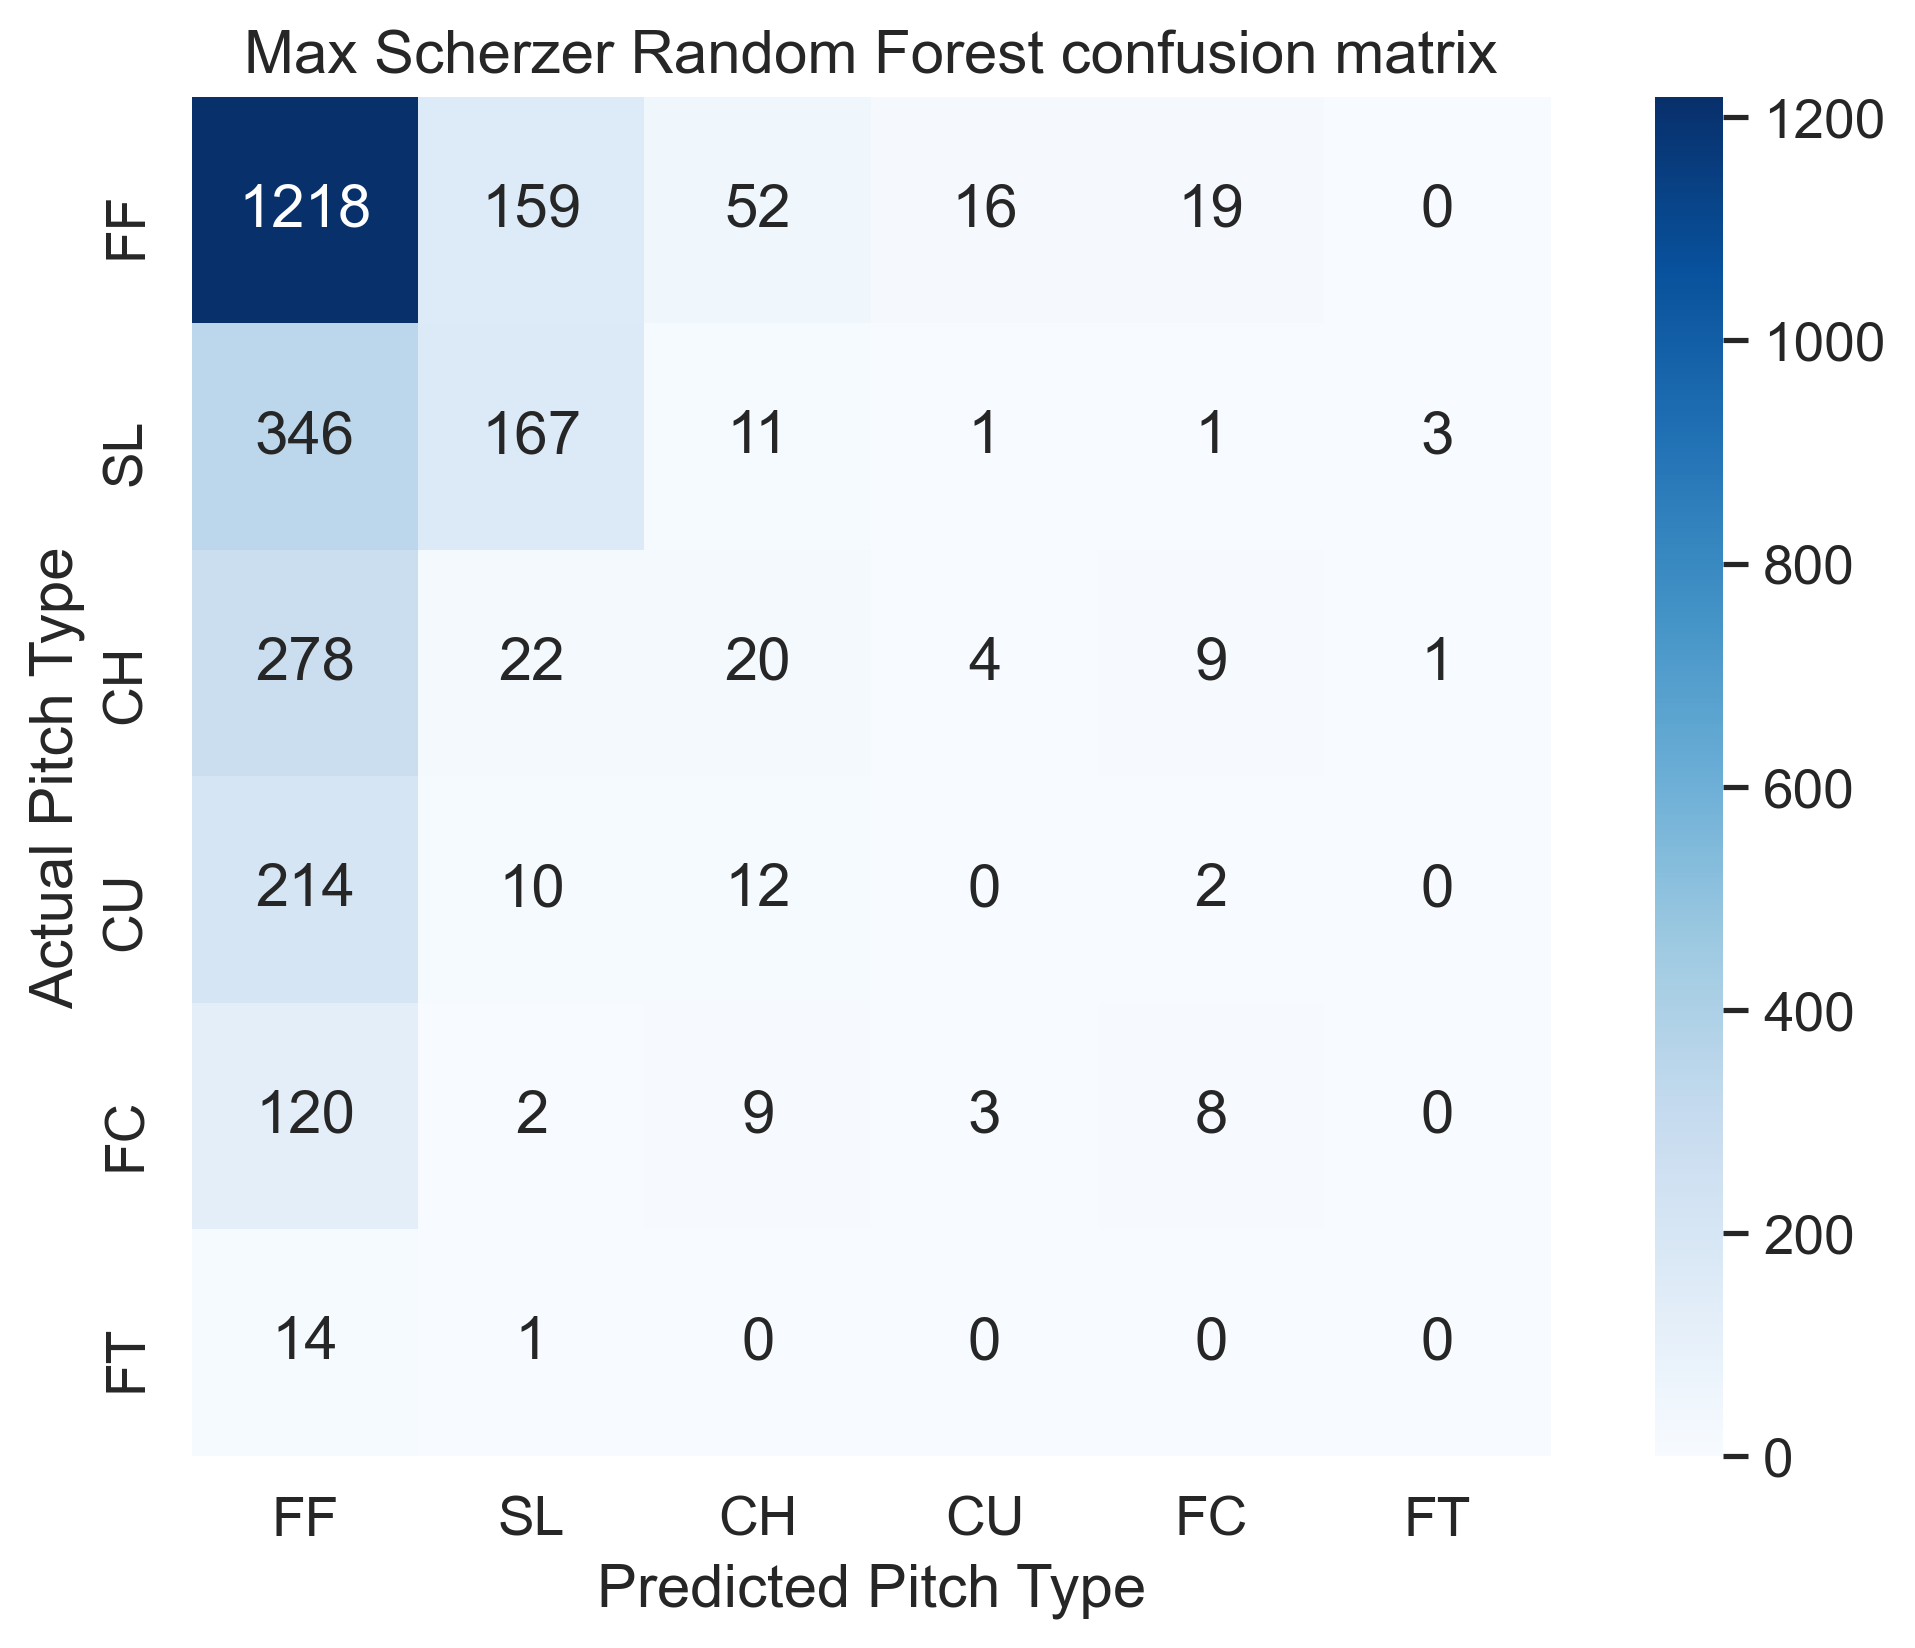

In [94]:
random_forest_pitch_pipeline('Max Scherzer', train_df_clusters, ohe_cols, col, k=5)

### RA Dickey:

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1484   12    0]
 [ 214   22    0]
 [  38    0    0]]


Confusion Matrix for Fold 2
[[1468   25    0]
 [ 210   27    0]
 [  40    0    0]]


Confusion Matrix for Fold 3
[[1449   19    0]
 [ 238   20    0]
 [  44    0    0]]


Confusion Matrix for Fold 4
[[1463   17    0]
 [ 213   31    0]
 [  46    0    0]]


Confusion Matrix for Fold 5
[[1495   22    0]
 [ 192   26    0]
 [  35    0    0]]




RandomForestClassifier()

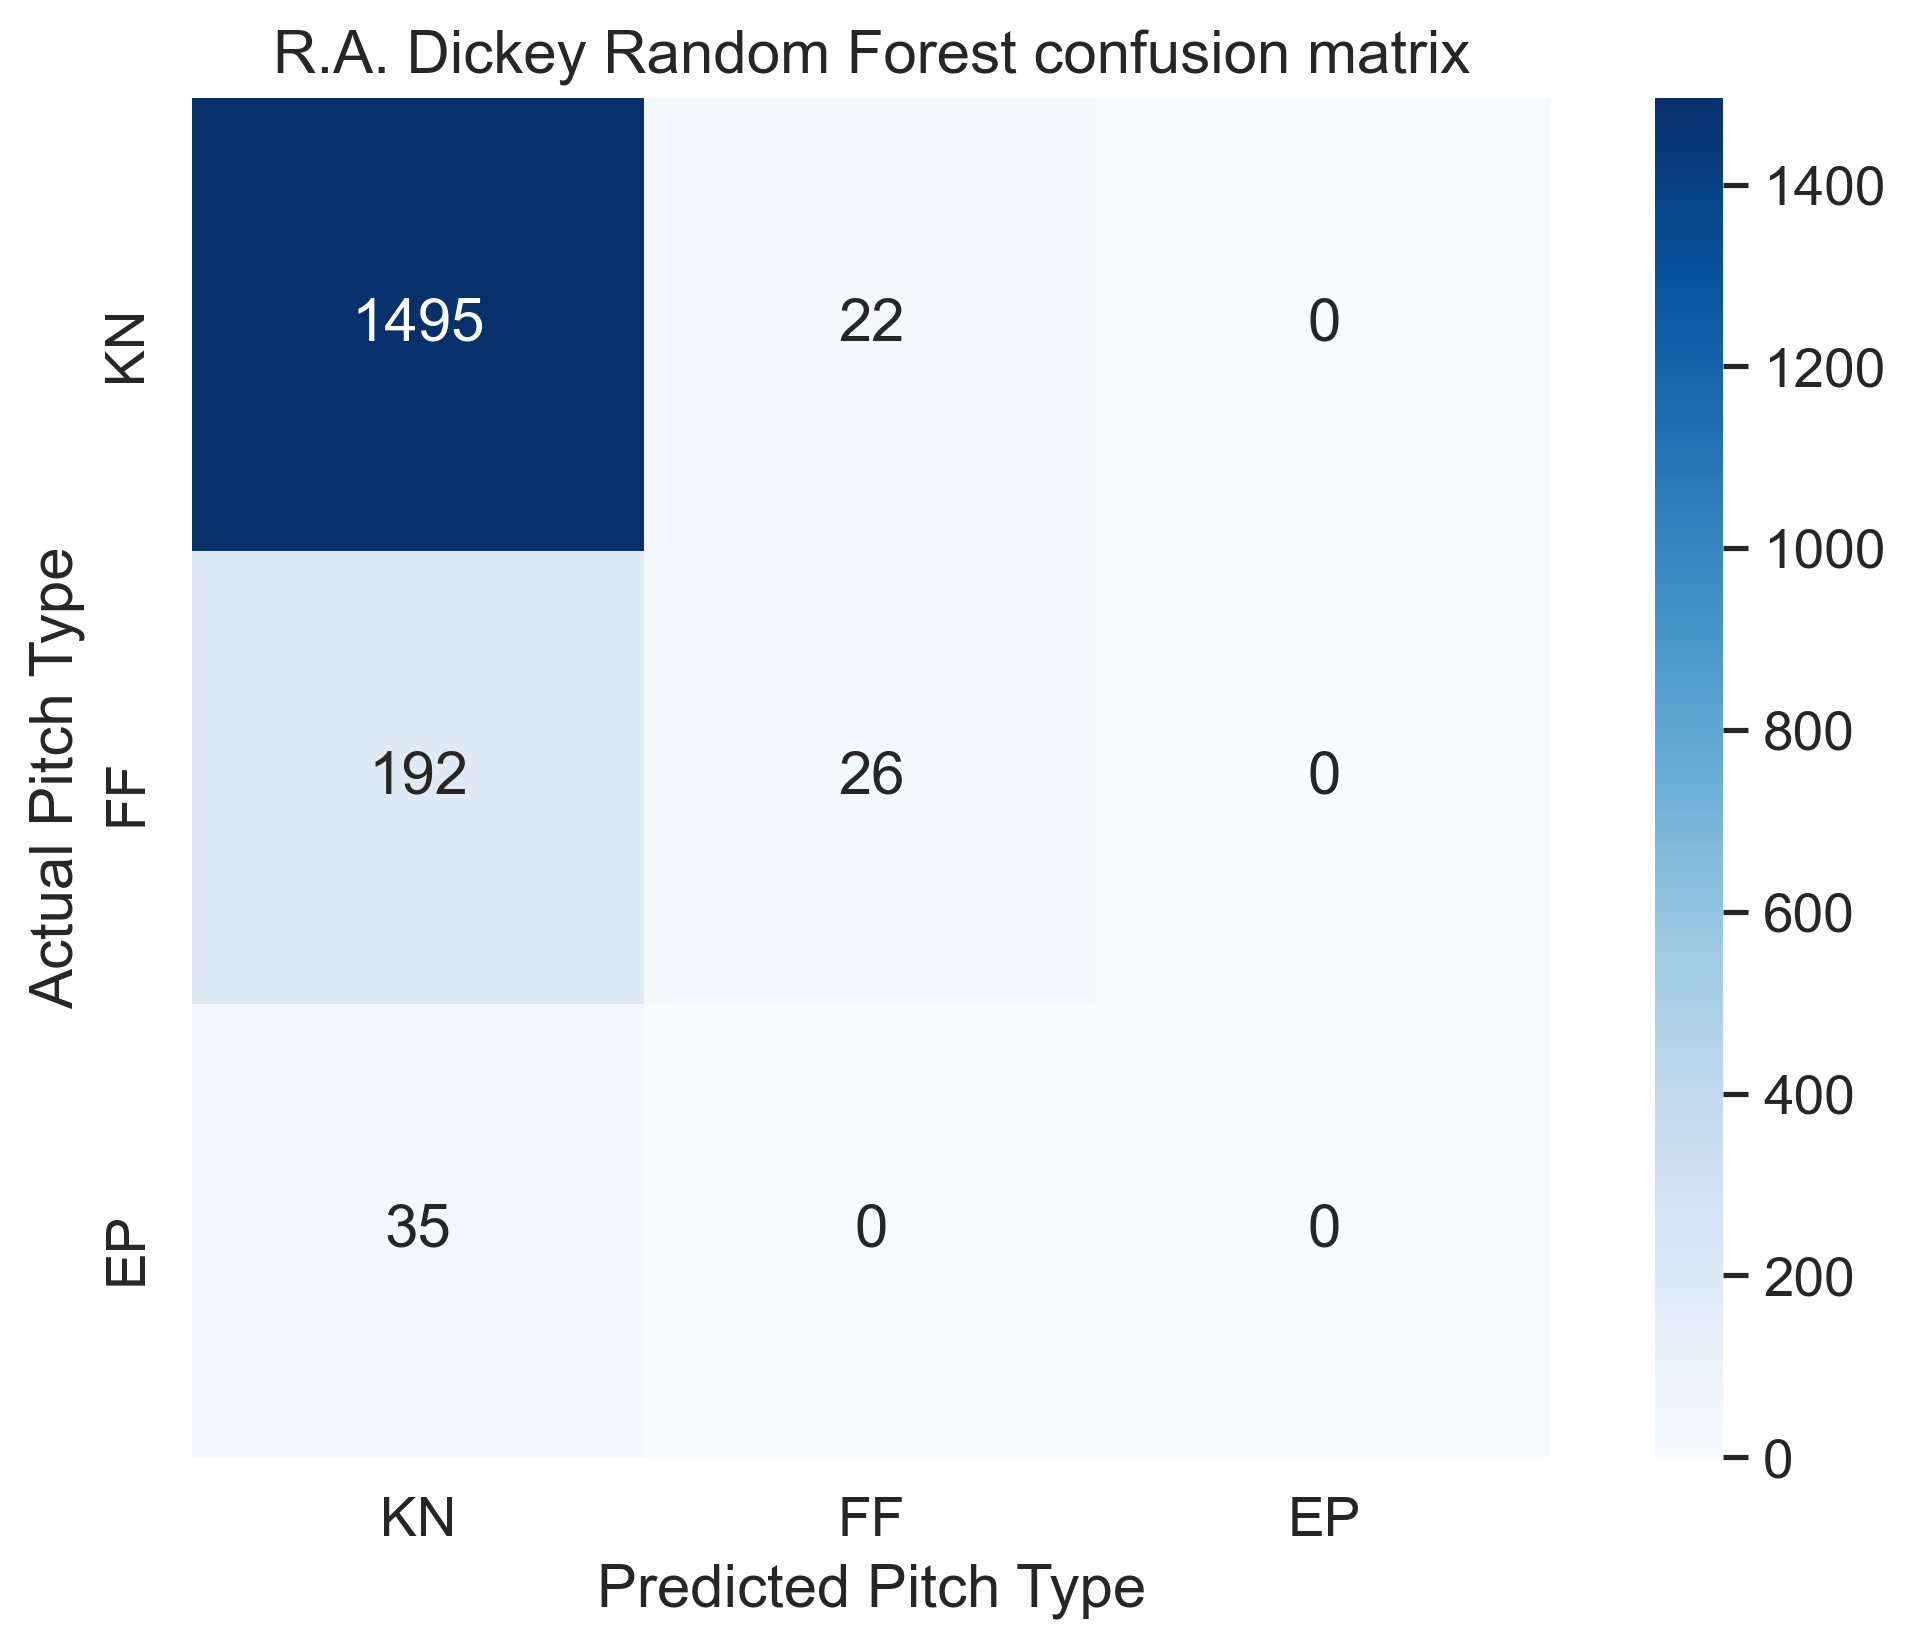

In [96]:
col = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF',
       'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

random_forest_pitch_pipeline('R.A. Dickey', train_df_clusters, ohe_cols, col, k=5)

### Clayton Kershaw:

In [100]:
kershaw_df = train_df_clusters[train_df_clusters.pitcher_full_name == 'Clayton Kershaw'].last_pitch_type.value_counts()

FF    5528
SL    3190
CU    1406
FT     161
CH      41
Name: last_pitch_type, dtype: int64

In [101]:
kershaw_df = train_df_clusters[train_df_clusters.pitcher_full_name == 'Clayton Kershaw']

In [102]:
ohe_cols

['stand', 'p_throws', 'last_pitch_type']

In [104]:
df = column_ohe_maker(kershaw_df, ohe_cols)

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Clayton Kershaw
Confusion Matrix for Fold 1
[[675 213  76   0   0]
 [365 275  72   1   0]
 [142 109  97   1   0]
 [ 16   5   5   2   0]
 [  5   5   2   0   0]]


Confusion Matrix for Fold 2
[[720 224  64   0   0]
 [352 266  61   0   0]
 [143 105  85   1   0]
 [ 26   5   2   2   0]
 [  4   1   4   0   0]]


Confusion Matrix for Fold 3
[[698 200  66   5   0]
 [379 270  67   1   0]
 [149  97 100   0   0]
 [ 18   2   5   1   0]
 [  2   3   2   0   0]]


Confusion Matrix for Fold 4
[[696 200  71   0   0]
 [360 264  64   0   0]
 [163 126  78   0   0]
 [ 19   5   4   1   0]
 [  6   5   3   0   0]]


Confusion Matrix for Fold 5
[[707 221  63   0   0]
 [332 285  53   0   0]
 [156 111  93   0   0]
 [ 20   9   4   2   0]
 [  3   3   3   0   0]]




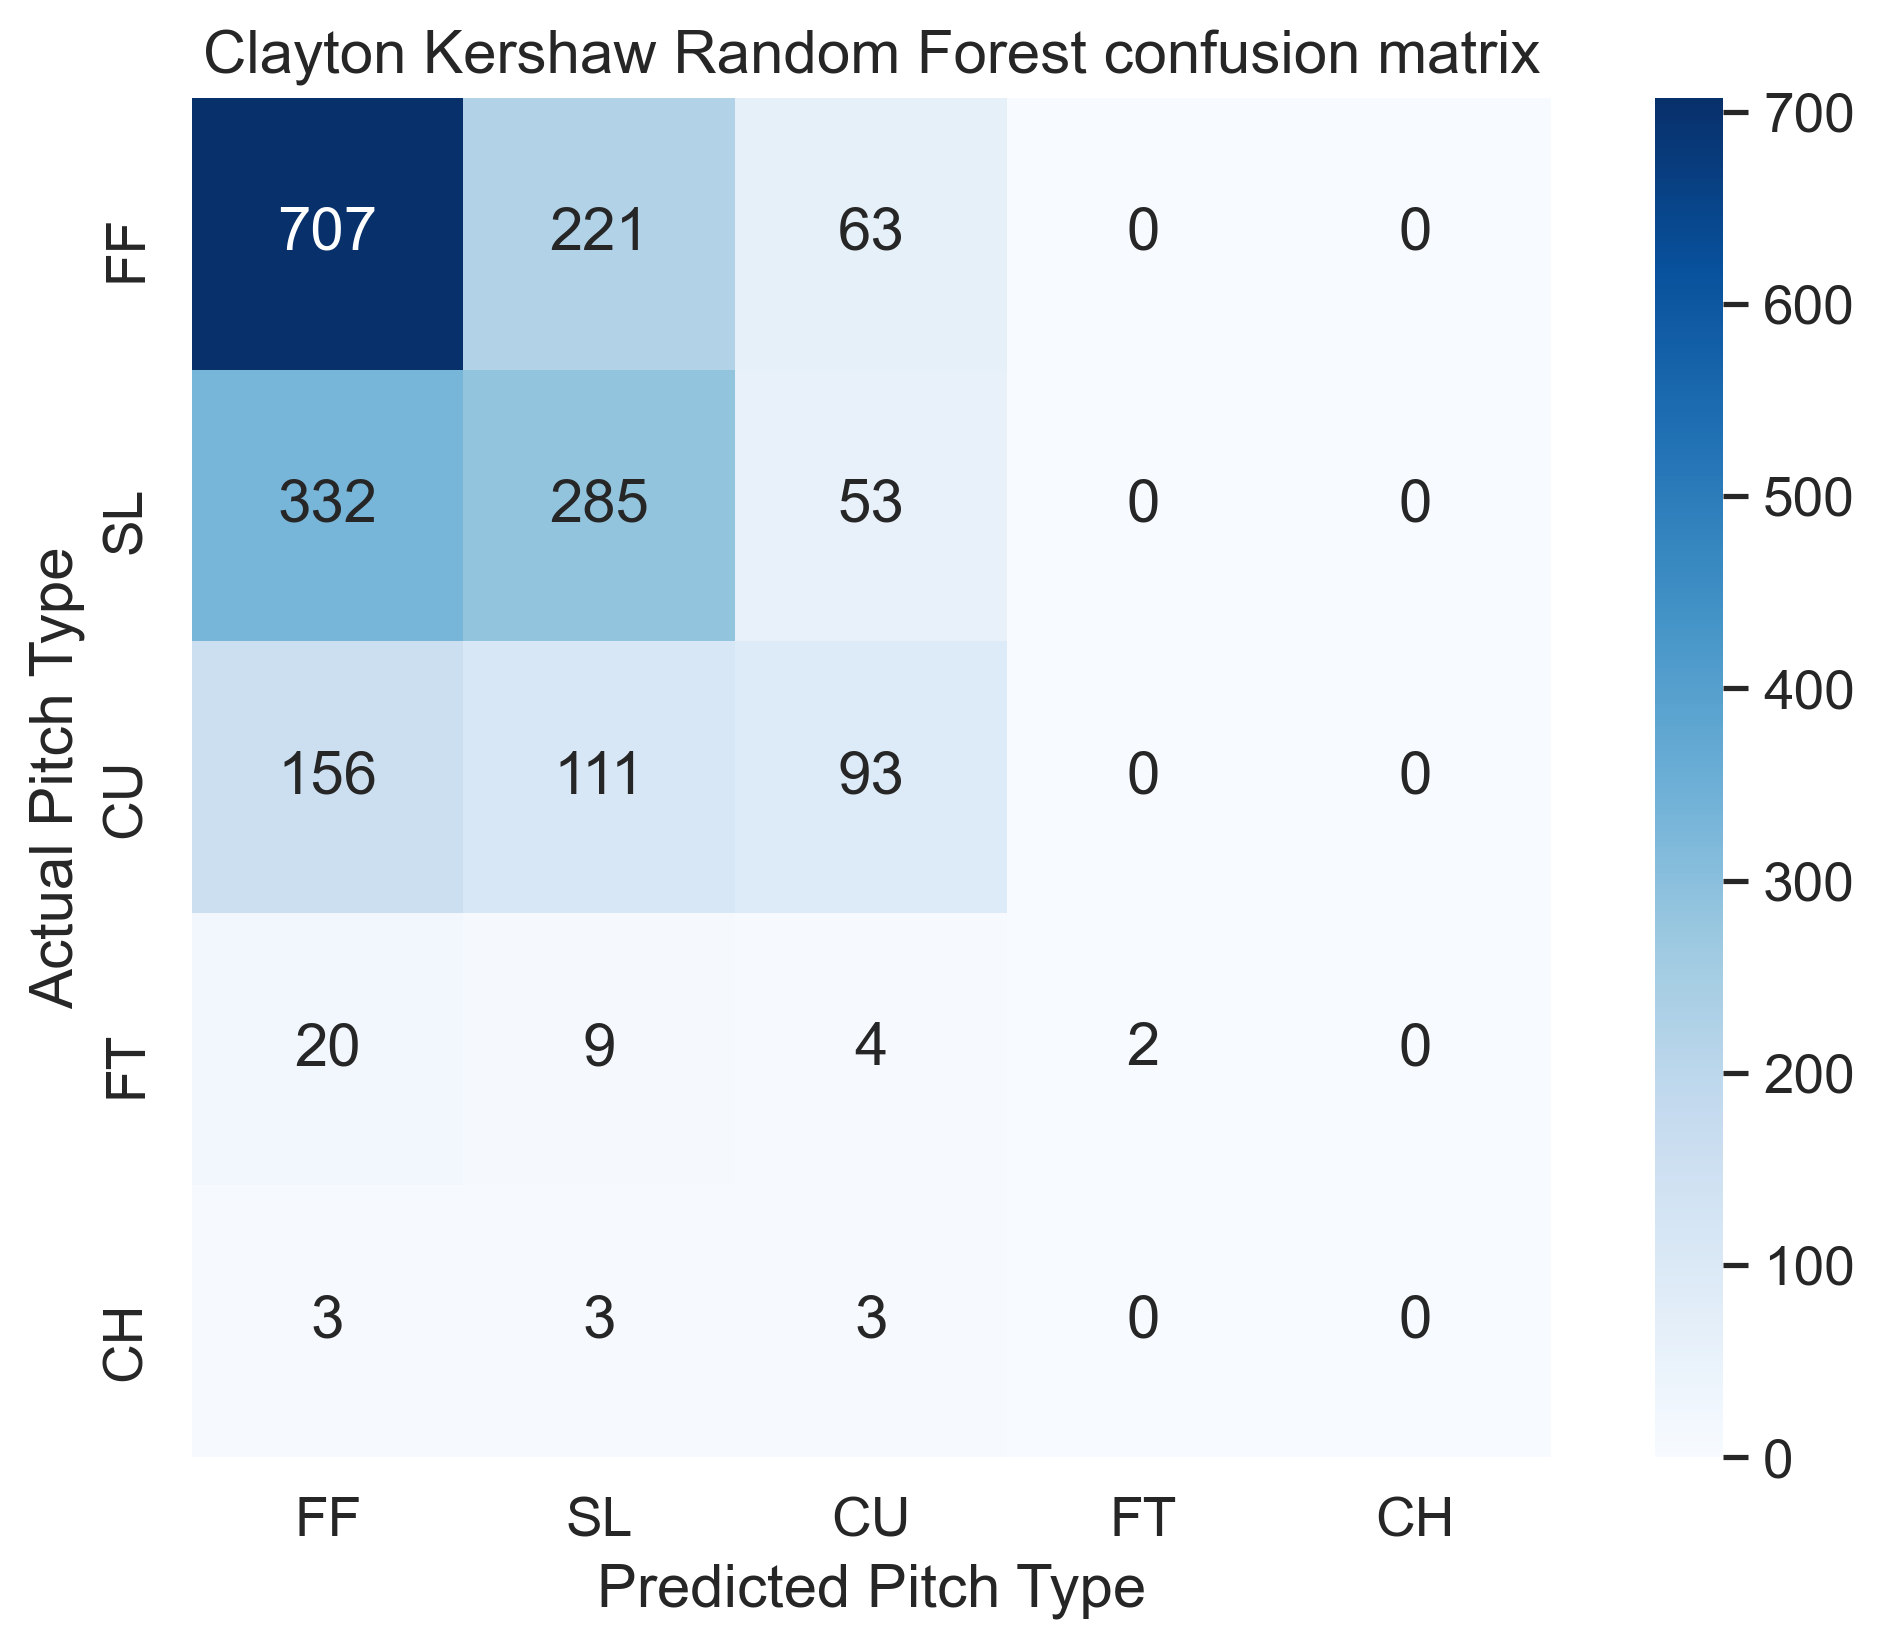

In [106]:
col = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_CU', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_None', 'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

colome_rf = random_forest_pitch_pipeline('Clayton Kershaw', train_df_clusters, ohe_cols, col, k=5)

# Error Analysis

Before going into more feature engineering, I'll take a look at where my model is having issues.

Similar to regression, I'll check out one pitcher to start to try to understand the overall model behavior.

### Alex Colome

In [107]:
my_list = [1,2,3,4,5]

In [109]:
mean(my_list)

NameError: name 'mean' is not defined